In [4]:
############################
# IMPORTACION DE LIBRERIAS #
############################

import numpy as np
import pandas as pd
import warnings
import matplotlib.pyplot as plt 
import seaborn as sns

%matplotlib inline

#warnings.filterwarnings('ignore')

from sklearn.preprocessing import StandardScaler
from sklearn.kernel_ridge import KernelRidge
from sklearn.metrics import mean_absolute_error, make_scorer
from sklearn.linear_model import RidgeCV, LassoCV, Ridge, Lasso, ElasticNetCV, ElasticNet, HuberRegressor
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor

In [2]:
##################
# CARGA DE DATOS #
##################e

traindata=pd.read_csv('Dataset_Salesforce_Predictive_Modelling_TRAIN.txt')#reading the data
testdata=pd.read_csv('Dataset_Salesforce_Predictive_Modelling_TEST.txt')
print('Number of rows and columns of the training set: ',traindata.shape)
print('Number of rows and columns of the test set: ',testdata.shape)


/home/rafa/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2698: DtypeWarning: Columns (83) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Number of rows and columns of the training set:  (363834, 89)
Number of rows and columns of the test set:  (156315, 88)


In [7]:
#VARIABLES DE CADA TIPO

traindata.dtypes.value_counts() 

int64      47
float64    40
object      2
dtype: int64

In [8]:
#VARIABLES DE CADA TIPO

numeric_cols=traindata.select_dtypes(include=[np.number]).columns#select only numerical
nominal_cols=traindata.select_dtypes(exclude=[np.number]).columns#select only non numerical
print(numeric_cols.shape[0],'numeric columns: ',numeric_cols)
print(nominal_cols.shape[0],'nominal columns: ',nominal_cols)

87 numeric columns:  Index(['Imp_Cons_01', 'Imp_Cons_02', 'Imp_Cons_03', 'Imp_Cons_04',
       'Imp_Cons_05', 'Imp_Cons_06', 'Imp_Cons_07', 'Imp_Cons_08',
       'Imp_Cons_09', 'Imp_Cons_10', 'Imp_Cons_11', 'Imp_Cons_12',
       'Imp_Cons_13', 'Imp_Cons_14', 'Imp_Cons_15', 'Imp_Cons_16',
       'Imp_Cons_17', 'Imp_Sal_01', 'Imp_Sal_02', 'Imp_Sal_03', 'Imp_Sal_04',
       'Imp_Sal_05', 'Imp_Sal_06', 'Imp_Sal_07', 'Imp_Sal_08', 'Imp_Sal_09',
       'Imp_Sal_10', 'Imp_Sal_11', 'Imp_Sal_12', 'Imp_Sal_13', 'Imp_Sal_14',
       'Imp_Sal_15', 'Imp_Sal_16', 'Imp_Sal_17', 'Imp_Sal_18', 'Imp_Sal_19',
       'Imp_Sal_20', 'Imp_Sal_21', 'Ind_Prod_01', 'Ind_Prod_02', 'Ind_Prod_03',
       'Ind_Prod_04', 'Ind_Prod_05', 'Ind_Prod_06', 'Ind_Prod_07',
       'Ind_Prod_08', 'Ind_Prod_09', 'Ind_Prod_10', 'Ind_Prod_11',
       'Ind_Prod_12', 'Ind_Prod_13', 'Ind_Prod_14', 'Ind_Prod_15',
       'Ind_Prod_16', 'Ind_Prod_17', 'Ind_Prod_18', 'Ind_Prod_19',
       'Ind_Prod_20', 'Ind_Prod_21', 'Ind_Prod_22', 'I

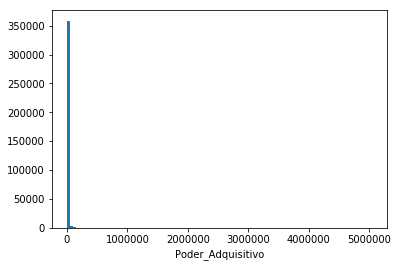

In [9]:
#BARPLOT DEL PODER ADQUISITIVO. 95% DE POBRES CON 5% DE RICOS. ASI DE BIEN VAN LAS COSAS
fig, ax = plt.subplots()
ax.hist(traindata['Poder_Adquisitivo'],100)
ax.set_xlabel('Poder_Adquisitivo')
plt.show()

In [10]:
#EL ID DEL CLIENTE NO NOS SIRVE PARA NADA


traindata=traindata.drop('ID_Customer',axis=1) #remove the column from train
test_ids = testdata['ID_Customer'] #save id column from test
testdata=testdata.drop('ID_Customer',axis=1) #remove the column from test
nominal_cols=nominal_cols[nominal_cols!='Id'] #remove the column name from this list as well

#CONCATENAMOS AMBOS CONJUNTOS PARA APLICAR TRANSFORMACIONES

data=pd.concat([traindata,testdata],axis=0,ignore_index=True) #concatenate training and test set for future transformations
print(data['Poder_Adquisitivo'].head())#Don't worry about the SalePrice variable that is not in test. 
print(data['Poder_Adquisitivo'].tail()) #It's filled with NAs

0    19709.915000
1    37497.492167
2     4802.970000
3     8295.770000
4    24149.321667
Name: Poder_Adquisitivo, dtype: float64
520144   NaN
520145   NaN
520146   NaN
520147   NaN
520148   NaN
Name: Poder_Adquisitivo, dtype: float64


In [12]:
###############################
# FUNCIONES PARA PREPROCESADO #
###############################

def iqr_calculate(column):
    description = column.describe()
    iqr = description['75%']-description['25%']
    return iqr

def outliers_limits(column):
    description = column.describe()
    iqr = iqr_calculate(column)
    outliers_limits = [description['25%']-1.5*iqr,description['75%']+1.5*iqr]
    return outliers_limits

def extreme_outliers_limits(column):
    description = column.describe()
    iqr = iqr_calculate(column)
    outliers_limits = [description['25%']-3*iqr,description['75%']+3*iqr]
    return outliers_limits

print ('Rango intercuartilico de variable objetivo:', iqr_calculate(traindata['Poder_Adquisitivo']))
print ('Limites (inferior y superior) de los valores atipicos:', outliers_limits(traindata['Poder_Adquisitivo']))
print ('Limites (inferior y superior) de los valores extremadamente atipicos:', extreme_outliers_limits(traindata['Poder_Adquisitivo']))



Rango intercuartilico de variable objetivo: 9647.60439575
Limites (inferior y superior) de los valores atipicos: [-5170.4740936249964, 33419.943489375]
Limites (inferior y superior) de los valores extremadamente atipicos: [-19641.880687249992, 47891.350082999998]


count    3.638340e+05
mean     1.642141e+04
std      2.436773e+04
min      3.600960e+03
25%      9.300933e+03
50%      1.292517e+04
75%      1.894854e+04
max      5.040000e+06
Name: Poder_Adquisitivo, dtype: float64
limits (lower,upper) [-5170.4740936249964, 33419.943489375]
Valores anomalos 20840


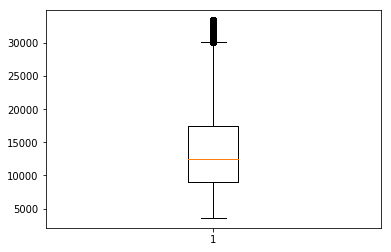

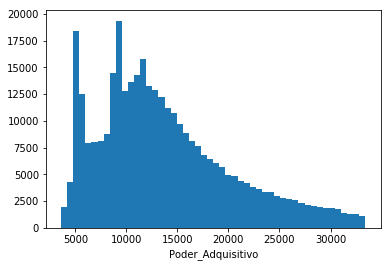

Imp_Cons_01


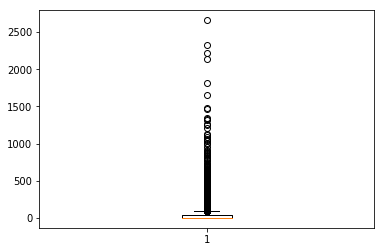

Imp_Cons_02


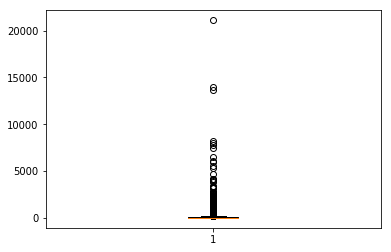

Imp_Cons_03


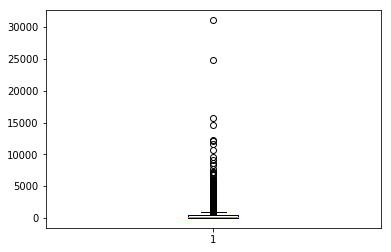

Imp_Cons_04


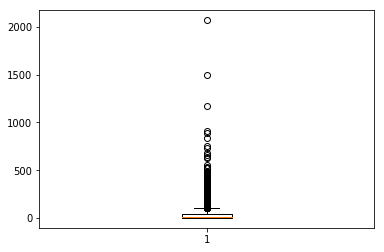

Imp_Cons_05


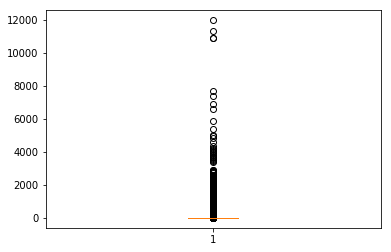

Imp_Cons_06


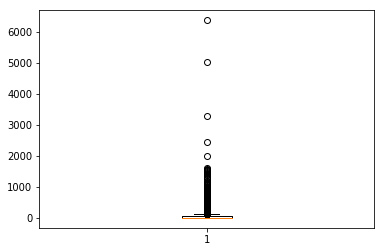

Imp_Cons_07


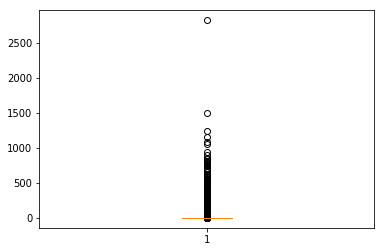

Imp_Cons_08


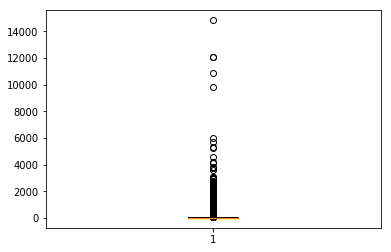

Imp_Cons_09


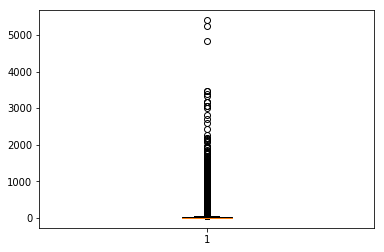

Imp_Cons_10


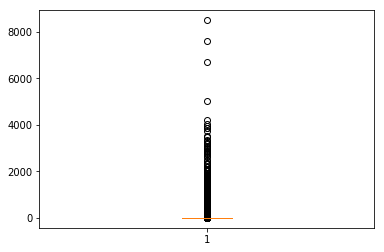

Imp_Cons_11


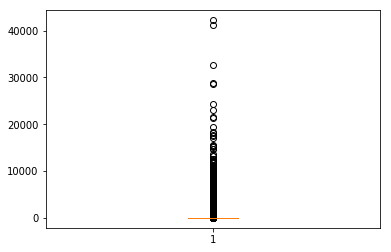

Imp_Cons_12


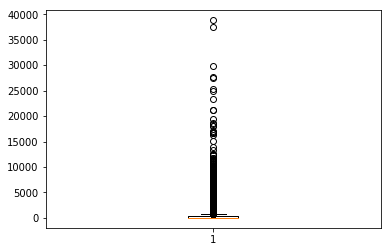

Imp_Cons_13


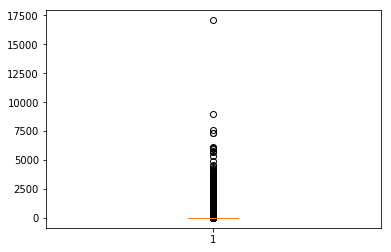

Imp_Cons_14


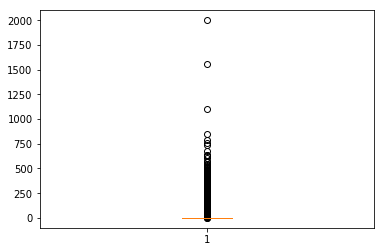

Imp_Cons_15


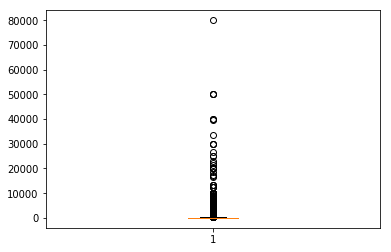

Imp_Cons_16


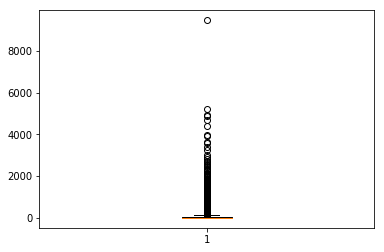

Imp_Cons_17


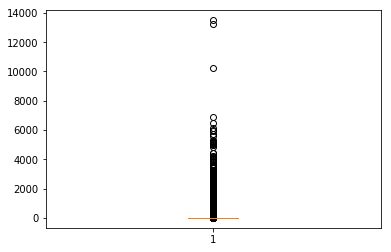

Imp_Sal_01


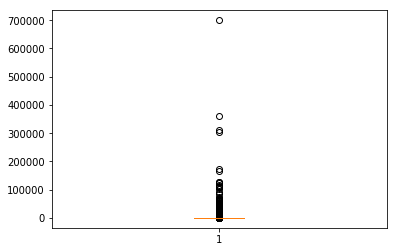

Imp_Sal_02


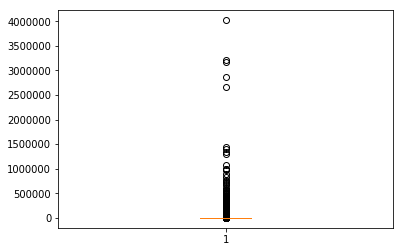

Imp_Sal_03


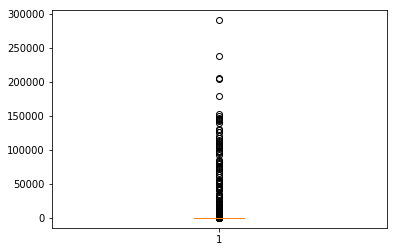

Imp_Sal_04


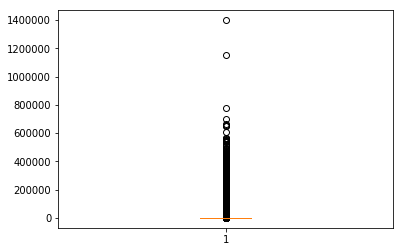

Imp_Sal_05


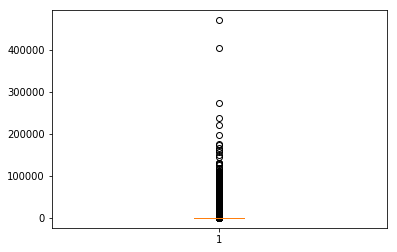

Imp_Sal_06


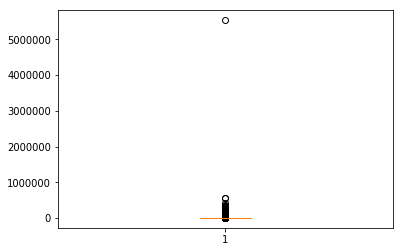

Imp_Sal_07


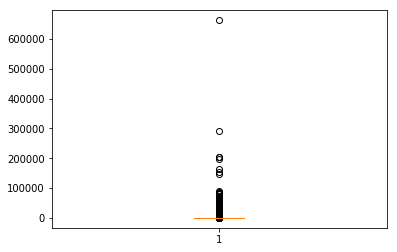

Imp_Sal_08


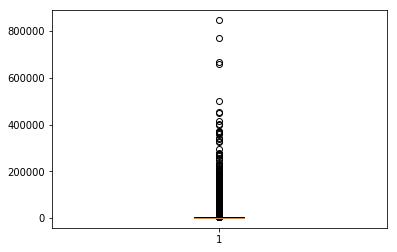

Imp_Sal_09


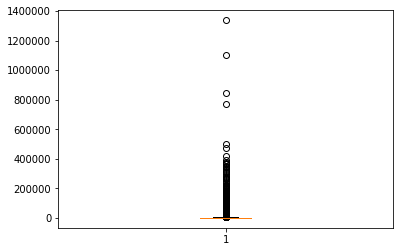

Imp_Sal_10


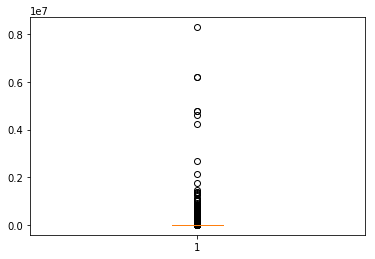

Imp_Sal_11


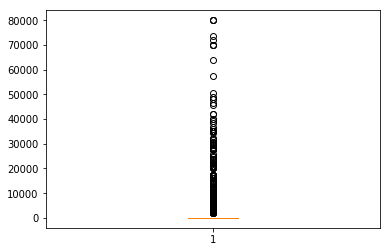

Imp_Sal_12


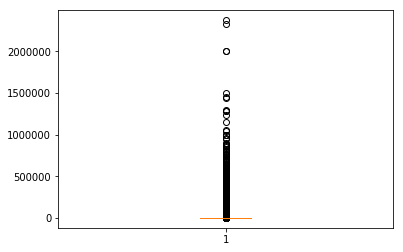

Imp_Sal_13


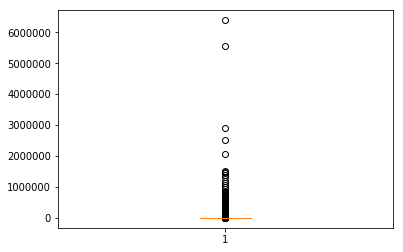

Imp_Sal_14


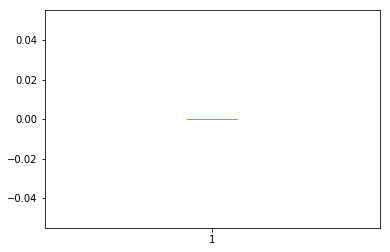

Imp_Sal_15


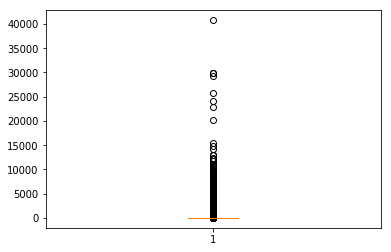

Imp_Sal_16


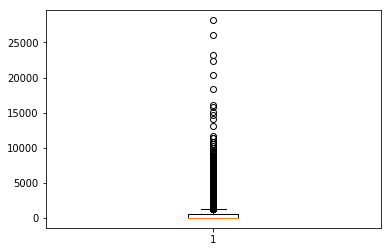

Imp_Sal_17


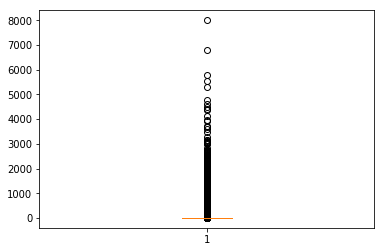

Imp_Sal_18


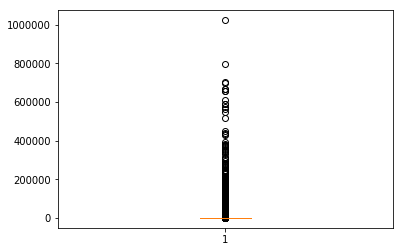

Imp_Sal_19


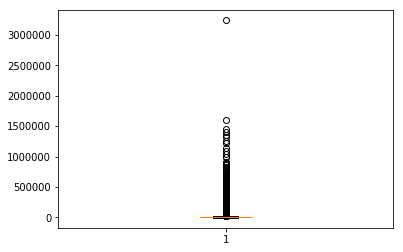

Imp_Sal_20


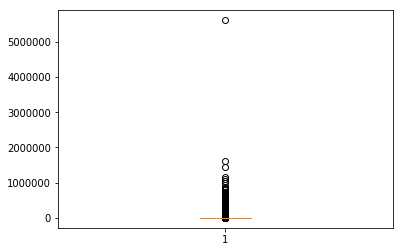

Imp_Sal_21


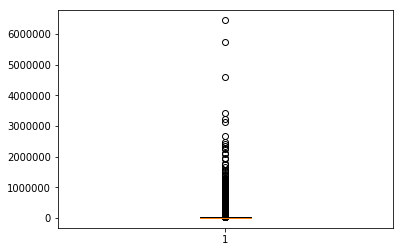

Ind_Prod_01


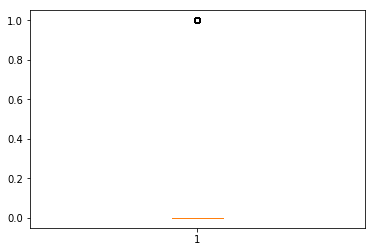

Ind_Prod_02


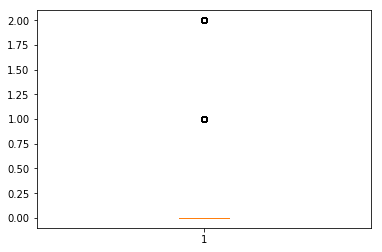

Ind_Prod_03


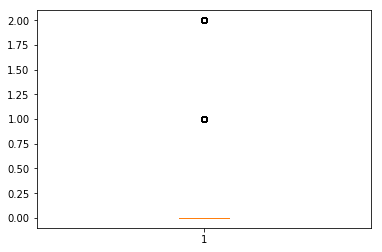

Ind_Prod_04


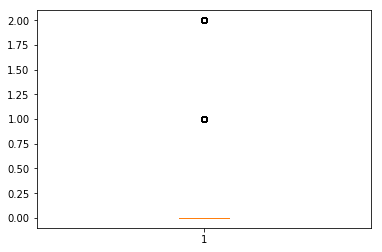

Ind_Prod_05


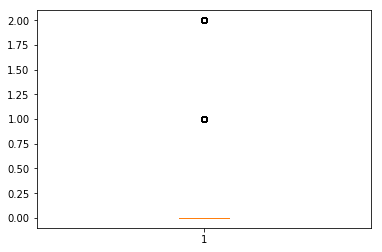

Ind_Prod_06


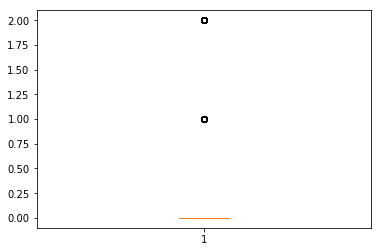

Ind_Prod_07


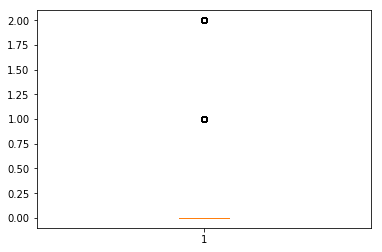

Ind_Prod_08


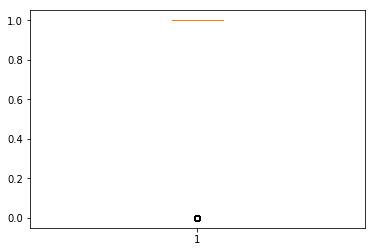

Ind_Prod_09


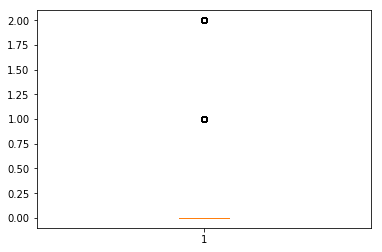

Ind_Prod_10


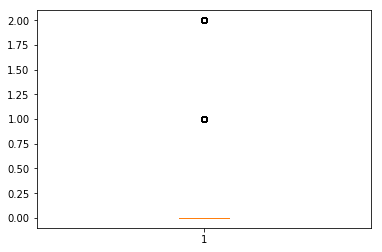

Ind_Prod_11


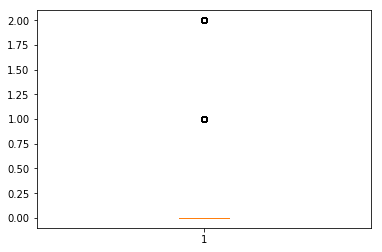

Ind_Prod_12


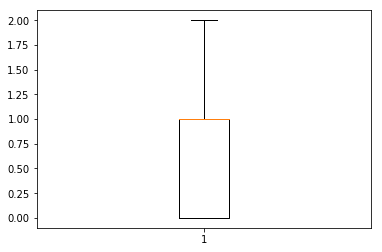

Ind_Prod_13


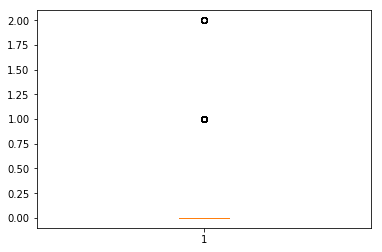

Ind_Prod_14


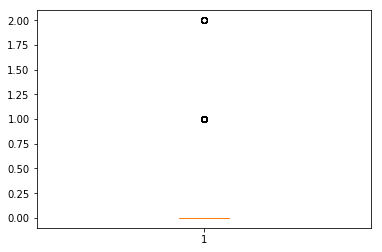

Ind_Prod_15


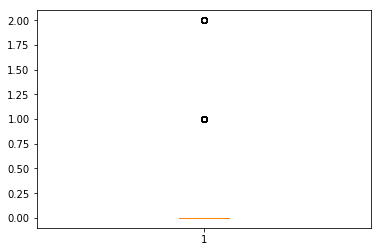

Ind_Prod_16


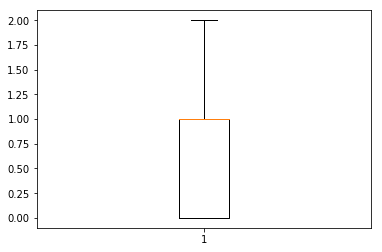

Ind_Prod_17


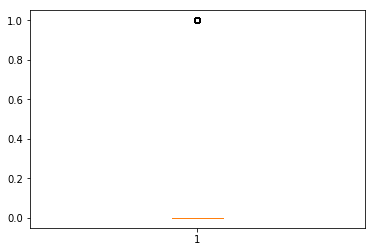

Ind_Prod_18


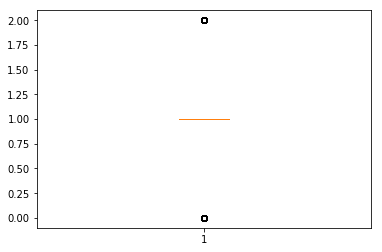

Ind_Prod_19


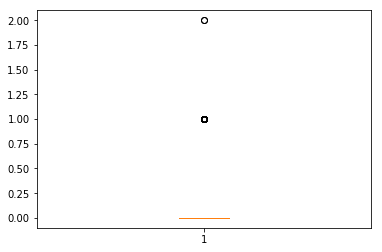

Ind_Prod_20


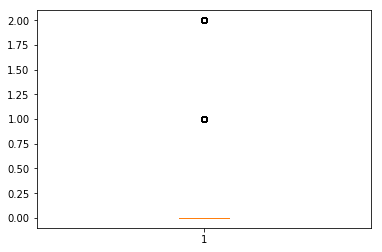

Ind_Prod_21


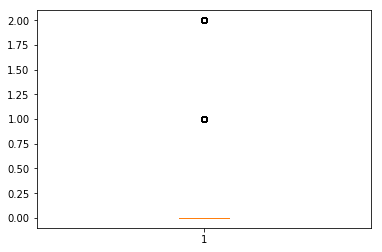

Ind_Prod_22


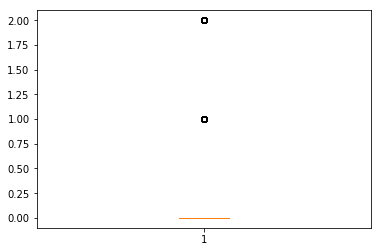

Ind_Prod_23


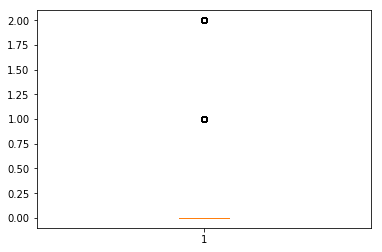

Ind_Prod_24


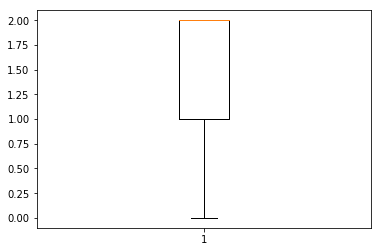

Num_Oper_01


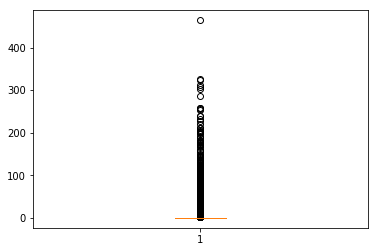

Num_Oper_02


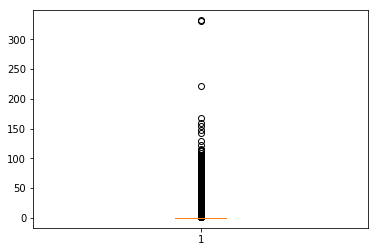

Num_Oper_03


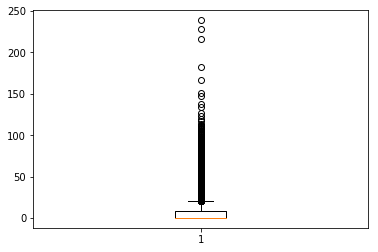

Num_Oper_04


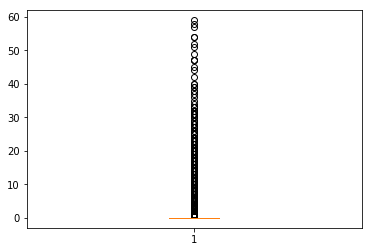

Num_Oper_05


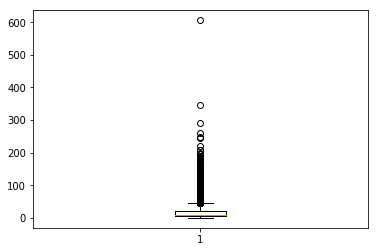

Num_Oper_06


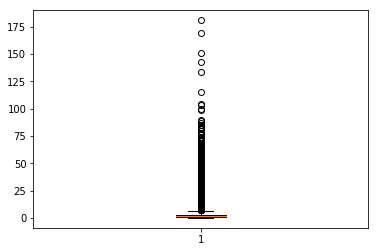

Num_Oper_07


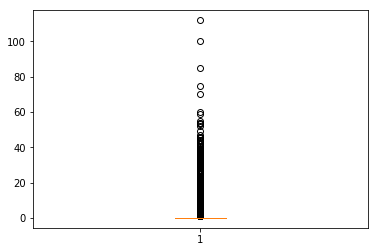

Num_Oper_08


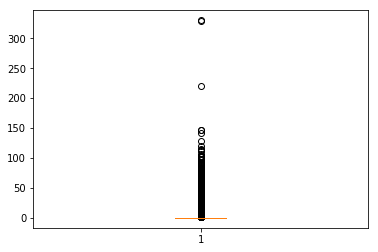

Num_Oper_09


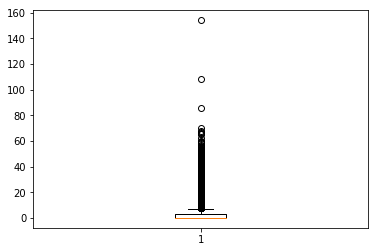

Num_Oper_10


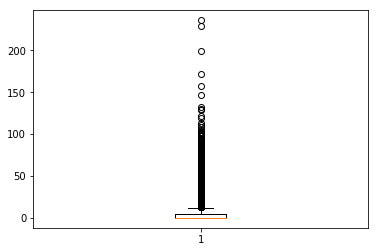

Num_Oper_11


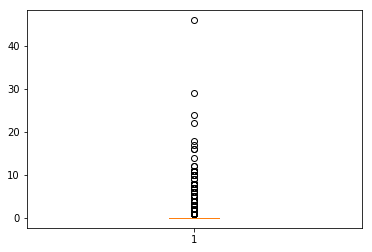

Num_Oper_12


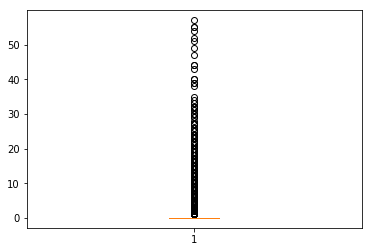

Num_Oper_13


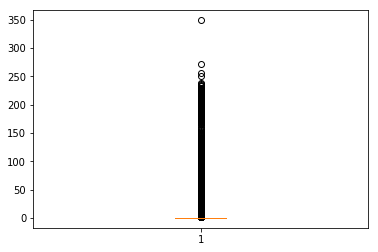

Num_Oper_14


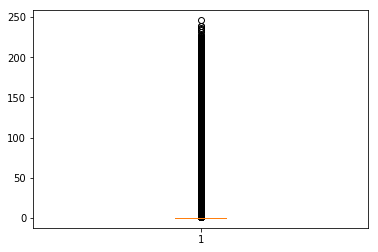

Num_Oper_15


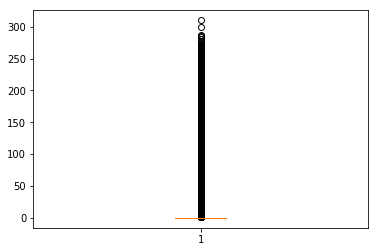

Num_Oper_16


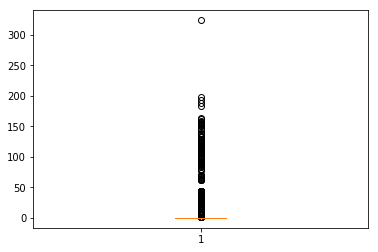

Num_Oper_17


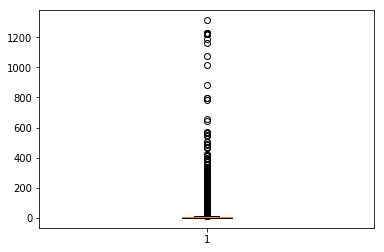

Num_Oper_18


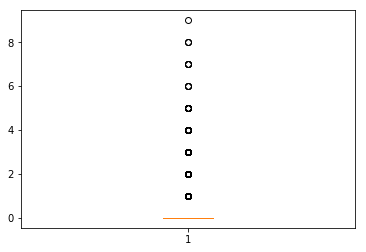

Num_Oper_19


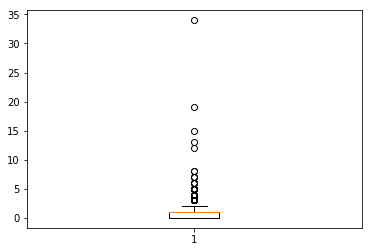

Num_Oper_20


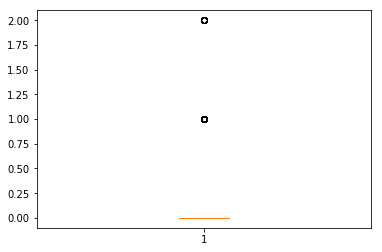

Socio_Demo_02


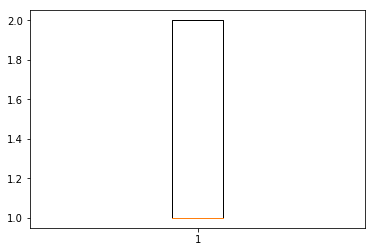

Socio_Demo_03


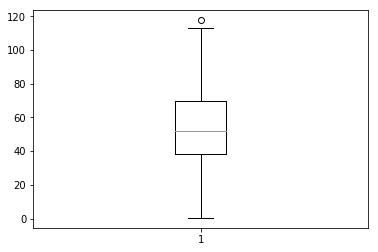

Socio_Demo_04


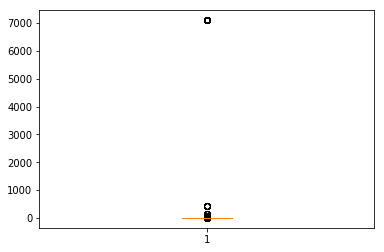

Socio_Demo_05


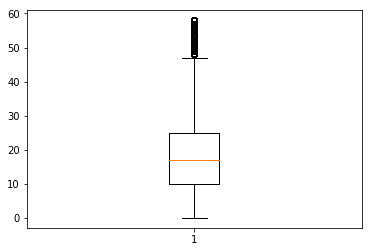

limits (lower,upper) [-55.913125500000007, 93.188542500000011]
Imp_Cons_01 without outliers
Numero de valores anomalos 0


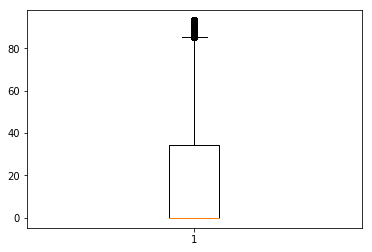

Histograma:


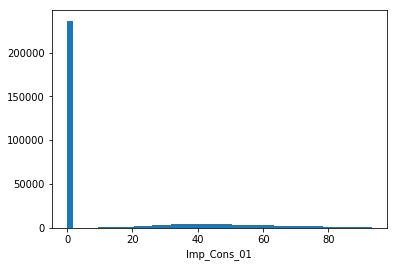

limits (lower,upper) [-126.17812499999999, 210.296875]
Imp_Cons_02 without outliers
Numero de valores anomalos 0


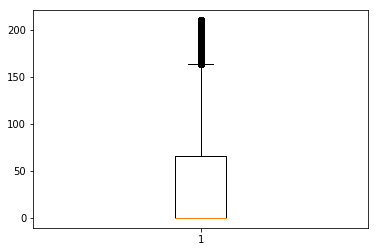

Histograma:


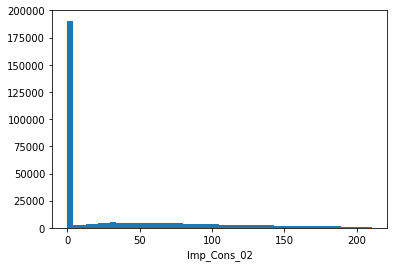

limits (lower,upper) [-600.0, 1000.0]
Imp_Cons_03 without outliers
Numero de valores anomalos 0


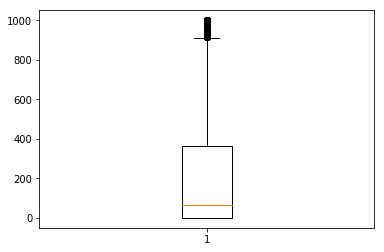

Histograma:


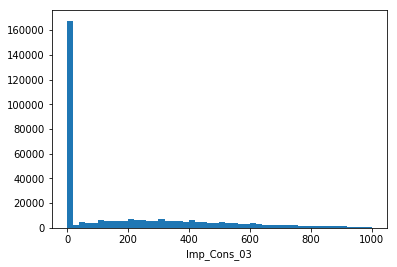

limits (lower,upper) [-59.969999999999999, 99.949999999999989]
Imp_Cons_04 without outliers
Numero de valores anomalos 0


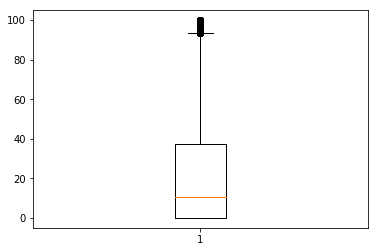

Histograma:


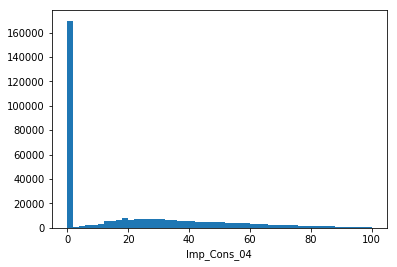

limits (lower,upper) [0.0, 0.0]
Imp_Cons_05 without outliers
Numero de valores anomalos 0


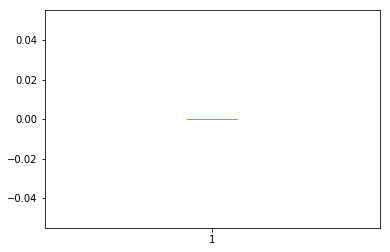

Histograma:


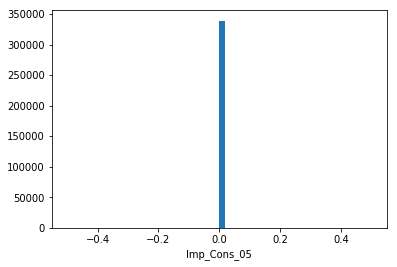

limits (lower,upper) [-78.122500500000001, 130.20416749999998]
Imp_Cons_06 without outliers
Numero de valores anomalos 0


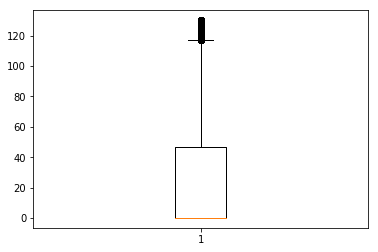

Histograma:


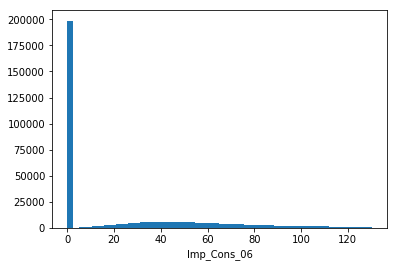

limits (lower,upper) [0.0, 0.0]
Imp_Cons_07 without outliers
Numero de valores anomalos 0


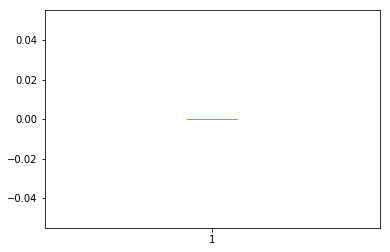

Histograma:


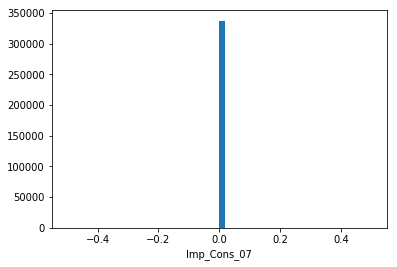

limits (lower,upper) [-60.0, 100.0]
Imp_Cons_08 without outliers
Numero de valores anomalos 0


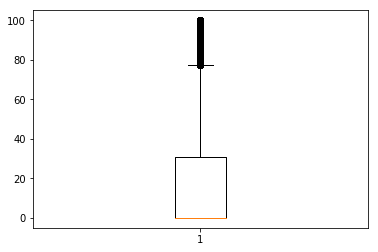

Histograma:


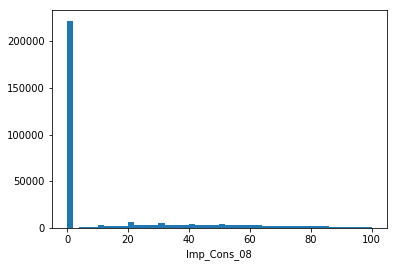

limits (lower,upper) [-39.450000000000003, 65.75]
Imp_Cons_09 without outliers
Numero de valores anomalos 0


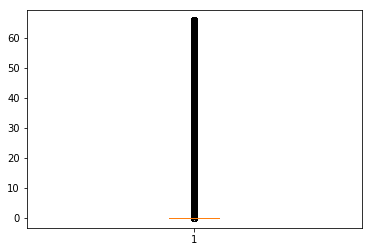

Histograma:


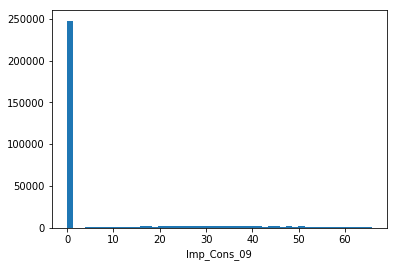

limits (lower,upper) [0.0, 0.0]
Imp_Cons_10 without outliers
Numero de valores anomalos 0


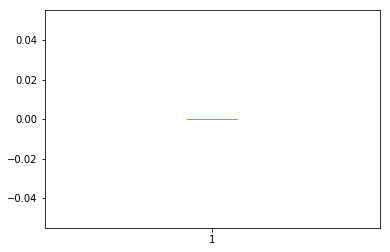

Histograma:


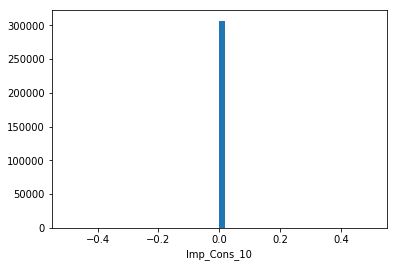

limits (lower,upper) [0.0, 0.0]
Imp_Cons_11 without outliers
Numero de valores anomalos 0


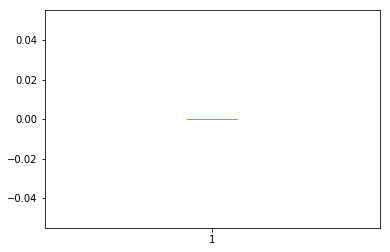

Histograma:


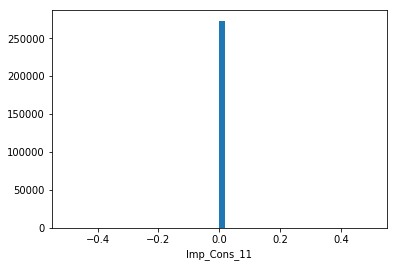

limits (lower,upper) [-489.72750000000002, 816.21250000000009]
Imp_Cons_12 without outliers
Numero de valores anomalos 0


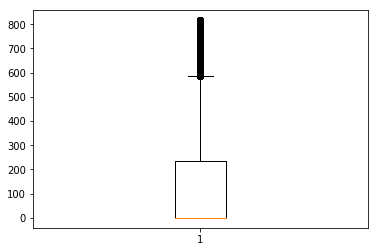

Histograma:


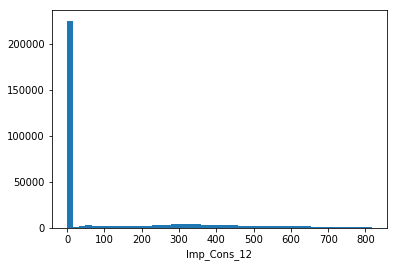

limits (lower,upper) [0.0, 0.0]
Imp_Cons_13 without outliers
Numero de valores anomalos 0


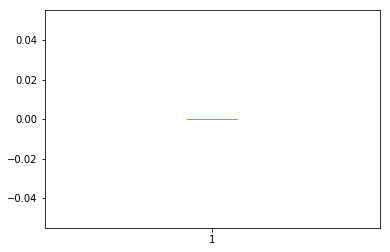

Histograma:


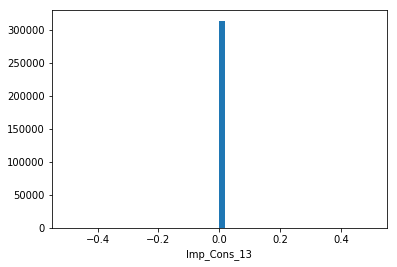

limits (lower,upper) [0.0, 0.0]
Imp_Cons_14 without outliers
Numero de valores anomalos 0


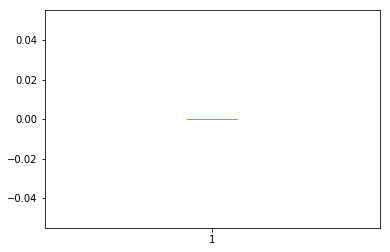

Histograma:


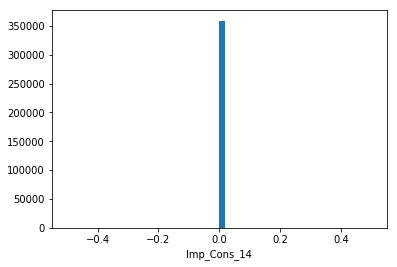

limits (lower,upper) [-235.93312499999999, 393.22187499999995]
Imp_Cons_15 without outliers
Numero de valores anomalos 0


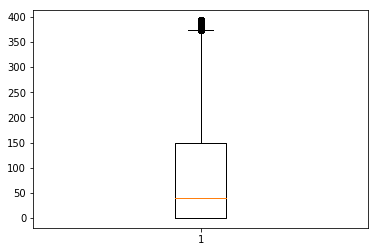

Histograma:


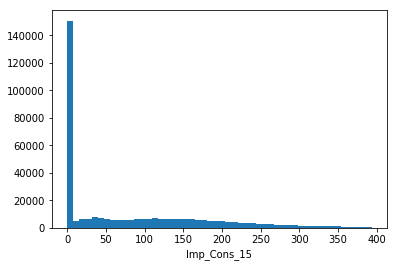

limits (lower,upper) [-84.734999999999999, 141.22499999999999]
Imp_Cons_16 without outliers
Numero de valores anomalos 0


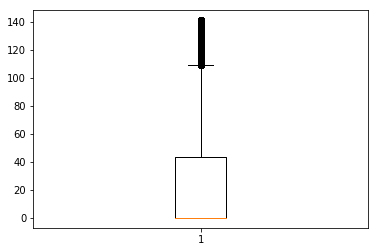

Histograma:


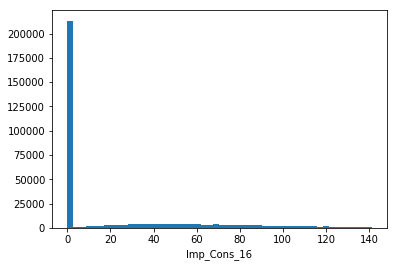

limits (lower,upper) [0.0, 0.0]
Imp_Cons_17 without outliers
Numero de valores anomalos 0


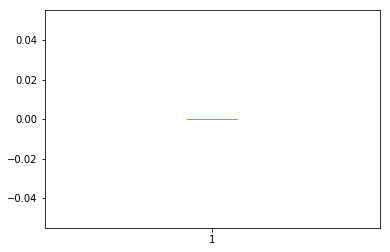

Histograma:


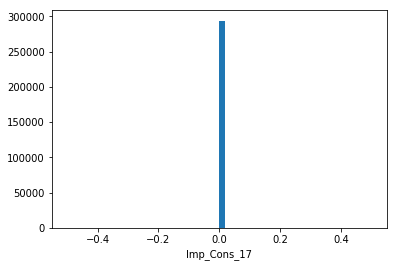

limits (lower,upper) [0.0, 0.0]
Imp_Sal_01 without outliers
Numero de valores anomalos 0


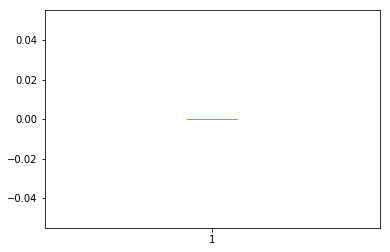

Histograma:


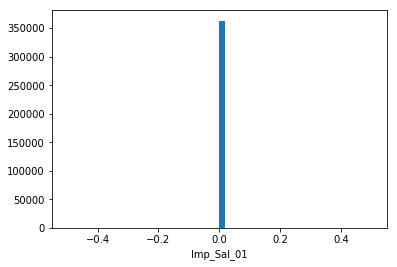

limits (lower,upper) [-49.999999500000001, 83.333332500000012]
Imp_Sal_02 without outliers
Numero de valores anomalos 0


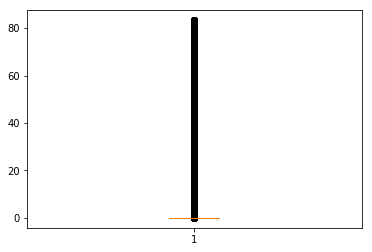

Histograma:


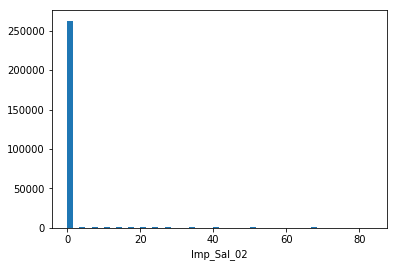

limits (lower,upper) [0.0, 0.0]
Imp_Sal_03 without outliers
Numero de valores anomalos 0


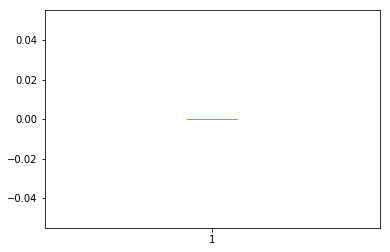

Histograma:


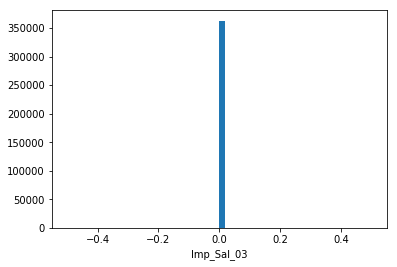

limits (lower,upper) [0.0, 0.0]
Imp_Sal_04 without outliers
Numero de valores anomalos 0


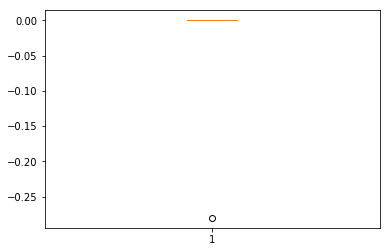

Histograma:


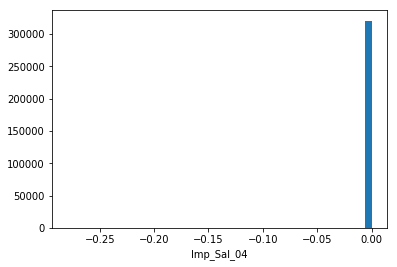

limits (lower,upper) [0.0, 0.0]
Imp_Sal_05 without outliers
Numero de valores anomalos 0


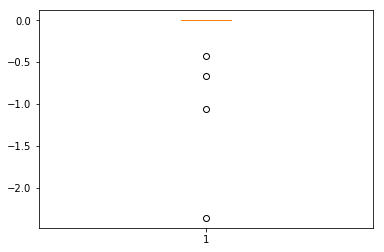

Histograma:


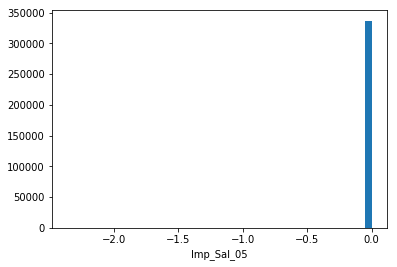

limits (lower,upper) [0.0, 0.0]
Imp_Sal_06 without outliers
Numero de valores anomalos 0


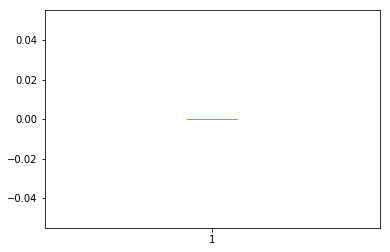

Histograma:


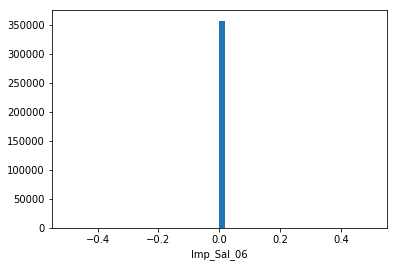

limits (lower,upper) [0.0, 0.0]
Imp_Sal_07 without outliers
Numero de valores anomalos 0


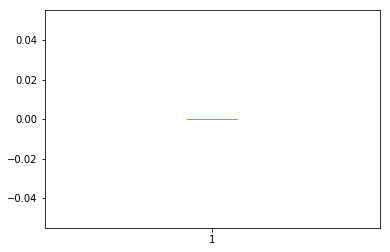

Histograma:


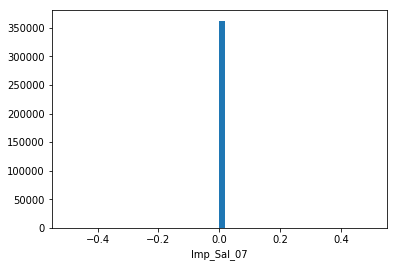

limits (lower,upper) [-1502.7766669999999, 4240.2633329999999]
Imp_Sal_08 without outliers
Numero de valores anomalos 0


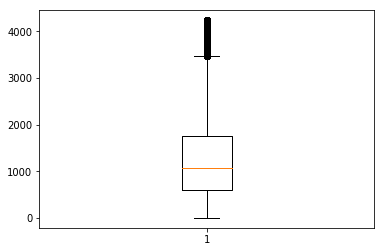

Histograma:


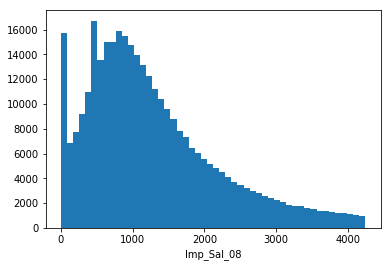

limits (lower,upper) [-1233.0766671249999, 3801.983333875]
Imp_Sal_09 without outliers
Numero de valores anomalos 0


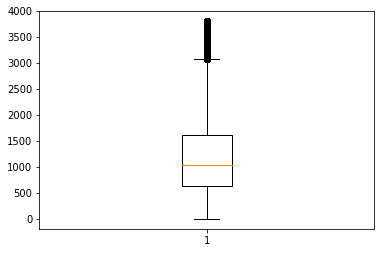

Histograma:


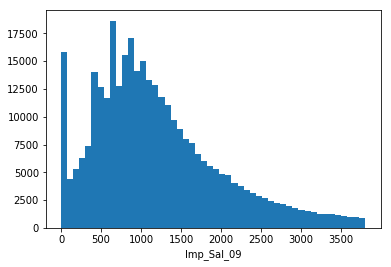

limits (lower,upper) [-535.05333250000001, 991.87999949999994]
Imp_Sal_10 without outliers
Numero de valores anomalos 0


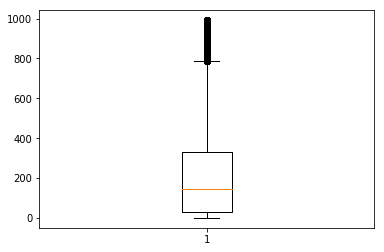

Histograma:


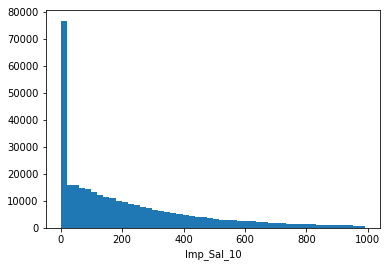

limits (lower,upper) [0.0, 0.0]
Imp_Sal_11 without outliers
Numero de valores anomalos 0


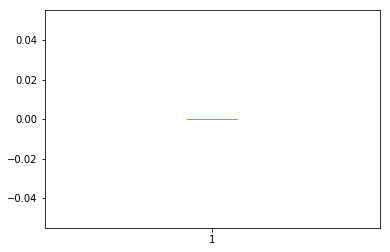

Histograma:


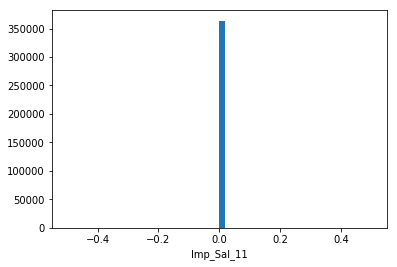

limits (lower,upper) [0.0, 0.0]
Imp_Sal_12 without outliers
Numero de valores anomalos 0


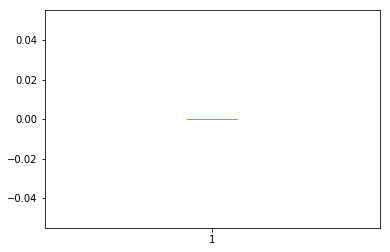

Histograma:


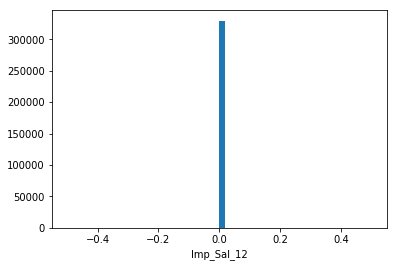

limits (lower,upper) [0.0, 0.0]
Imp_Sal_13 without outliers
Numero de valores anomalos 0


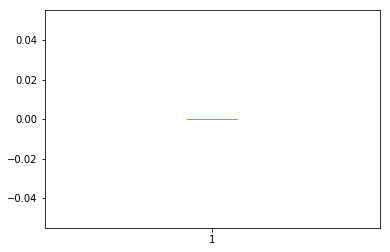

Histograma:


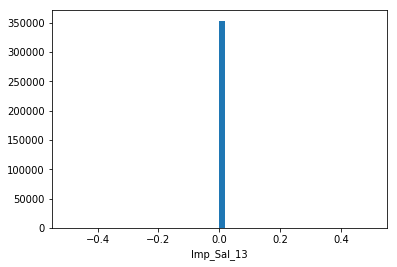

limits (lower,upper) [0.0, 0.0]
Imp_Sal_14 without outliers
Numero de valores anomalos 0


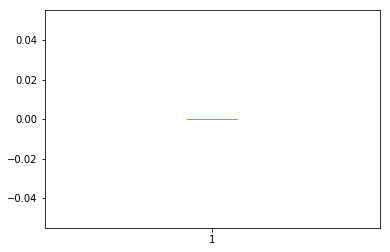

Histograma:


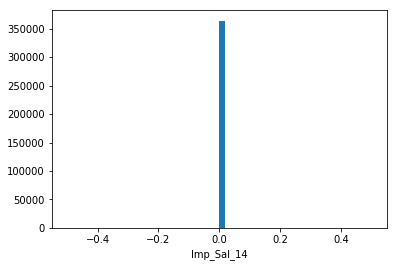

limits (lower,upper) [0.0, 0.0]
Imp_Sal_15 without outliers
Numero de valores anomalos 0


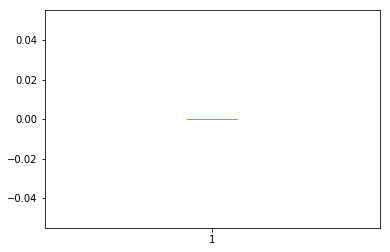

Histograma:


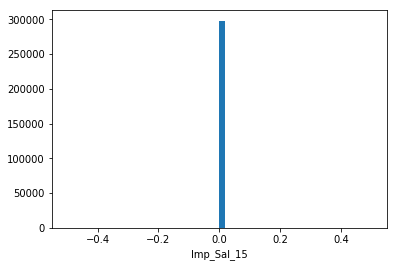

limits (lower,upper) [-784.61250037500008, 1307.6875006250002]
Imp_Sal_16 without outliers
Numero de valores anomalos 0


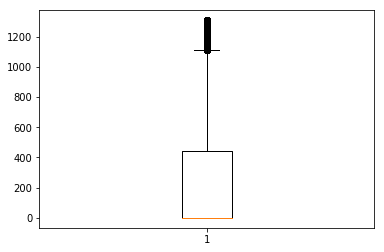

Histograma:


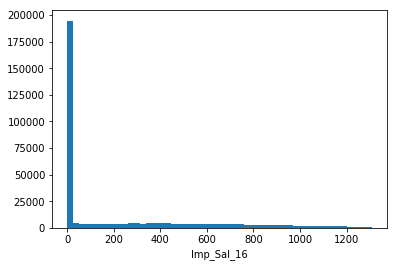

limits (lower,upper) [0.0, 0.0]
Imp_Sal_17 without outliers
Numero de valores anomalos 0


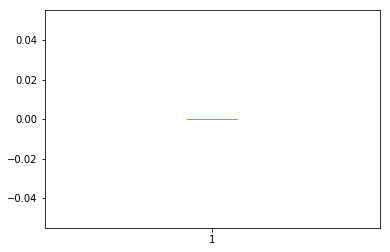

Histograma:


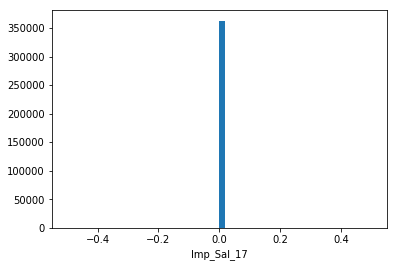

limits (lower,upper) [0.0, 0.0]
Imp_Sal_18 without outliers
Numero de valores anomalos 0


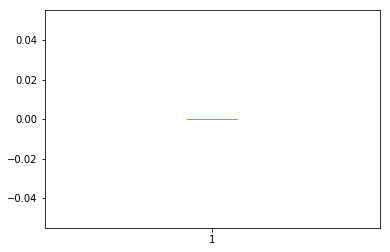

Histograma:


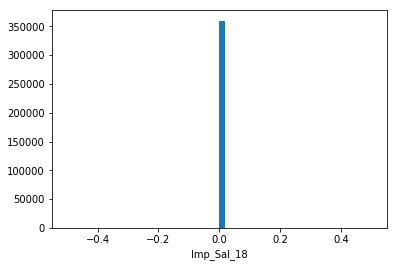

limits (lower,upper) [-12834.133750250001, 21814.476249749998]
Imp_Sal_19 without outliers
Numero de valores anomalos 3


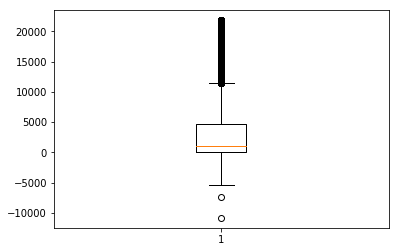

Histograma:


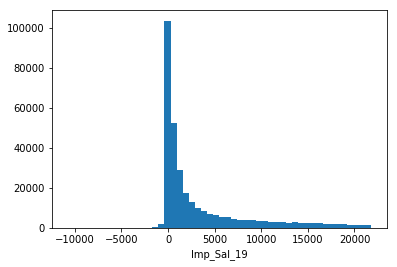

limits (lower,upper) [-1871.7662505000003, 3119.6104175000005]
Imp_Sal_20 without outliers
Numero de valores anomalos 0


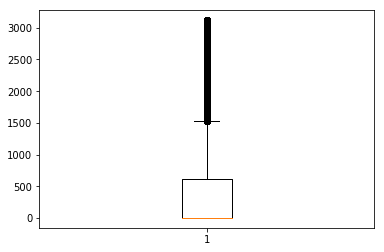

Histograma:


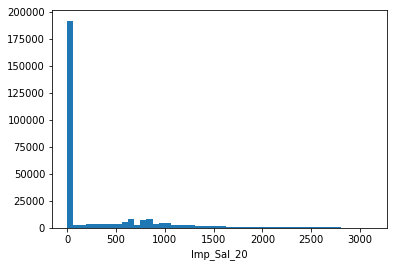

limits (lower,upper) [-21270.040417125001, 36160.396249875004]
Imp_Sal_21 without outliers
Numero de valores anomalos 3322


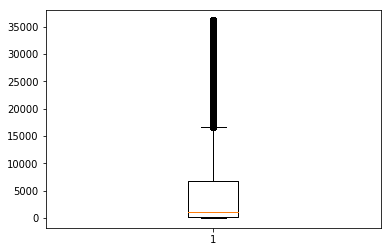

Histograma:


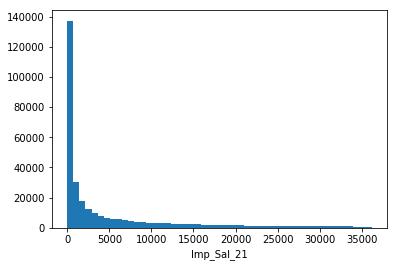

limits (lower,upper) [0.0, 0.0]
Ind_Prod_01 without outliers
Numero de valores anomalos 0


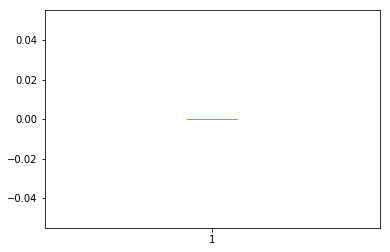

Histograma:


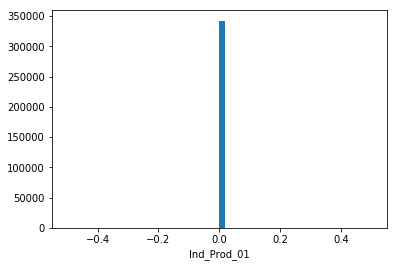

limits (lower,upper) [0.0, 0.0]
Ind_Prod_02 without outliers
Numero de valores anomalos 0


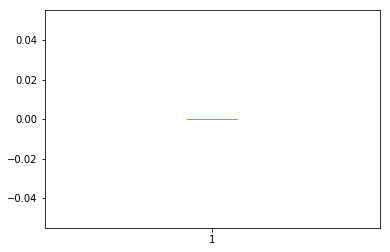

Histograma:


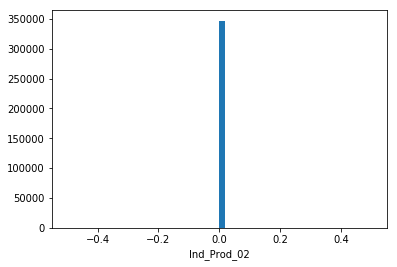

limits (lower,upper) [0.0, 0.0]
Ind_Prod_03 without outliers
Numero de valores anomalos 0


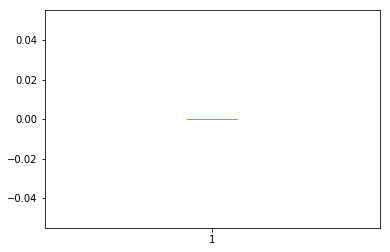

Histograma:


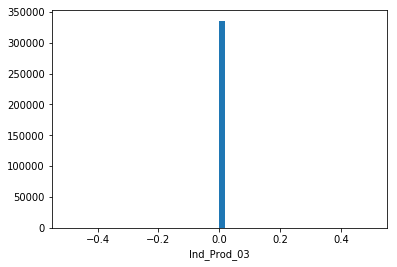

limits (lower,upper) [0.0, 0.0]
Ind_Prod_04 without outliers
Numero de valores anomalos 0


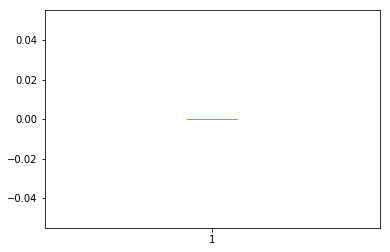

Histograma:


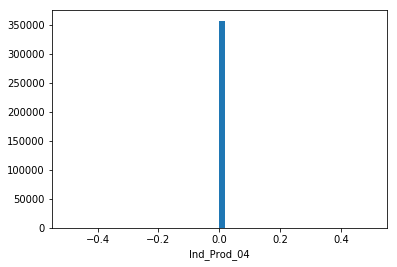

limits (lower,upper) [0.0, 0.0]
Ind_Prod_05 without outliers
Numero de valores anomalos 0


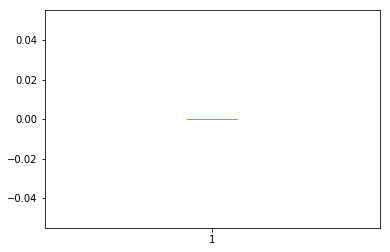

Histograma:


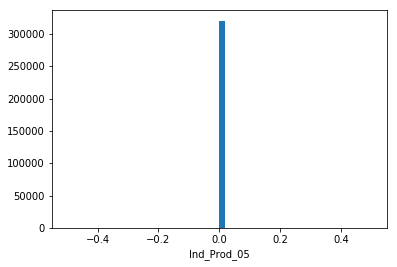

limits (lower,upper) [0.0, 0.0]
Ind_Prod_06 without outliers
Numero de valores anomalos 0


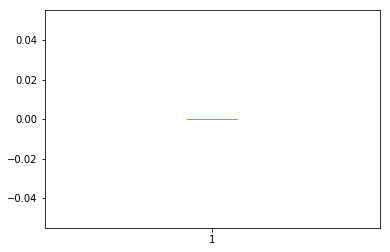

Histograma:


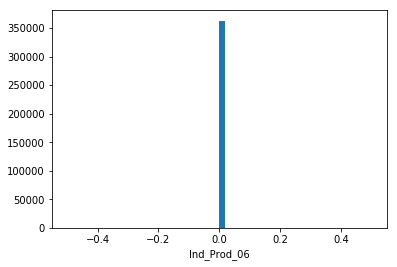

limits (lower,upper) [0.0, 0.0]
Ind_Prod_07 without outliers
Numero de valores anomalos 0


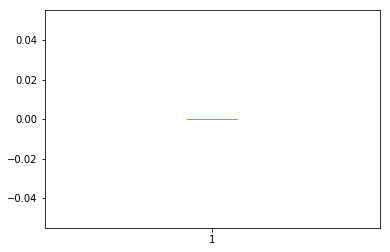

Histograma:


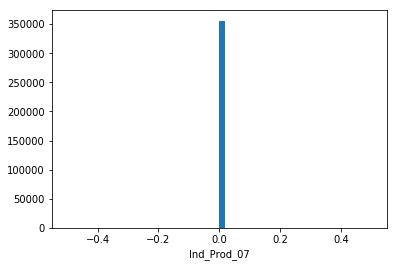

limits (lower,upper) [1.0, 1.0]
Ind_Prod_08 without outliers
Numero de valores anomalos 0


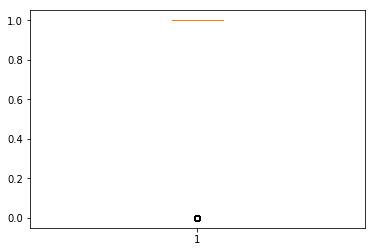

Histograma:


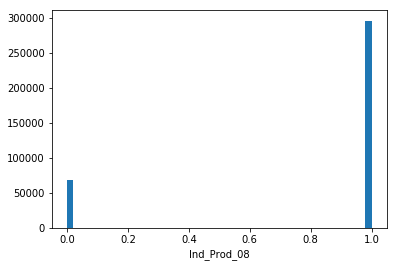

limits (lower,upper) [0.0, 0.0]
Ind_Prod_09 without outliers
Numero de valores anomalos 0


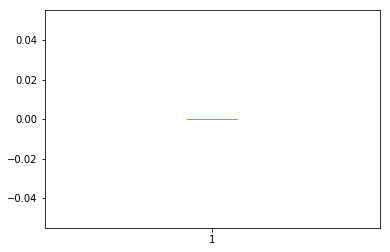

Histograma:


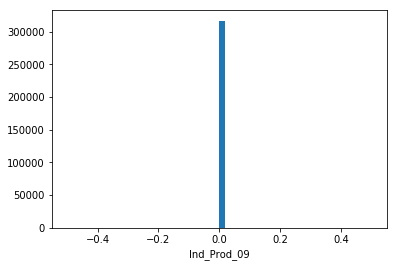

limits (lower,upper) [0.0, 0.0]
Ind_Prod_10 without outliers
Numero de valores anomalos 0


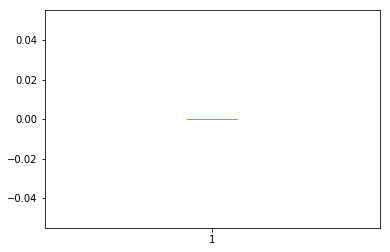

Histograma:


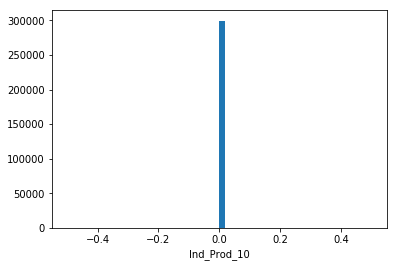

limits (lower,upper) [0.0, 0.0]
Ind_Prod_11 without outliers
Numero de valores anomalos 0


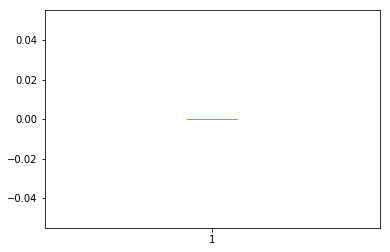

Histograma:


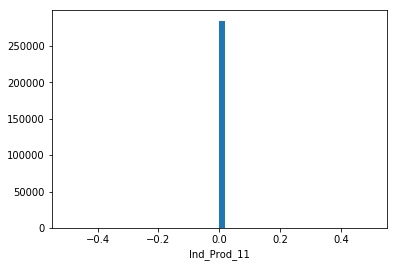

limits (lower,upper) [-1.5, 2.5]
Ind_Prod_12 without outliers
Numero de valores anomalos 0


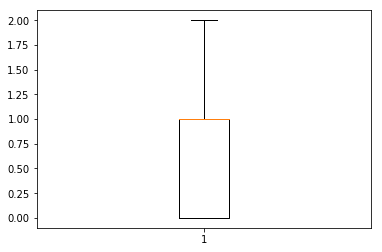

Histograma:


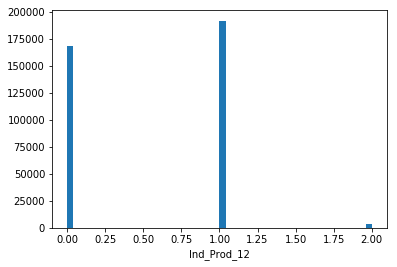

limits (lower,upper) [0.0, 0.0]
Ind_Prod_13 without outliers
Numero de valores anomalos 0


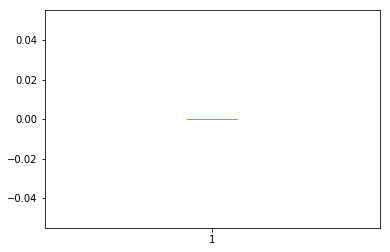

Histograma:


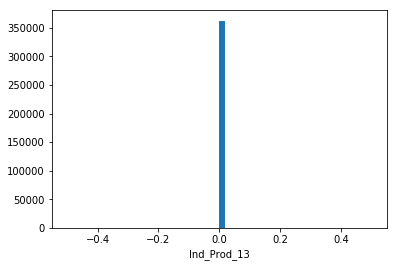

limits (lower,upper) [0.0, 0.0]
Ind_Prod_14 without outliers
Numero de valores anomalos 0


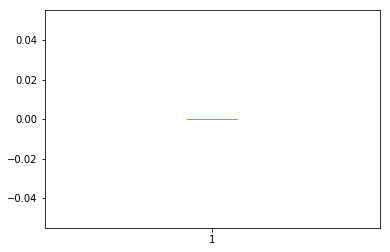

Histograma:


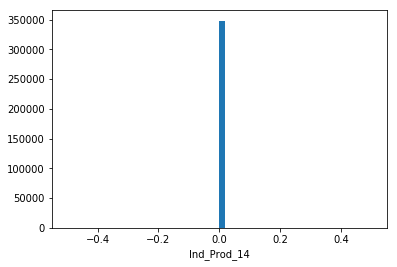

limits (lower,upper) [0.0, 0.0]
Ind_Prod_15 without outliers
Numero de valores anomalos 0


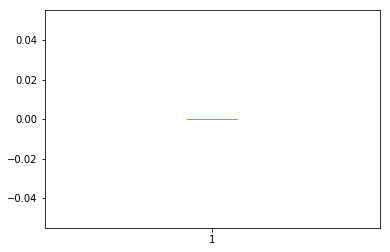

Histograma:


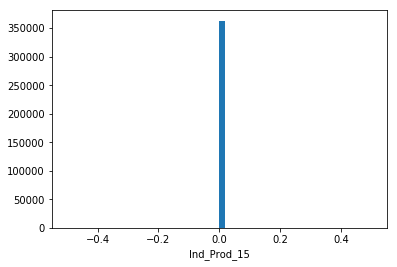

limits (lower,upper) [-1.5, 2.5]
Ind_Prod_16 without outliers
Numero de valores anomalos 0


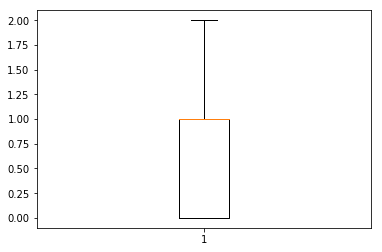

Histograma:


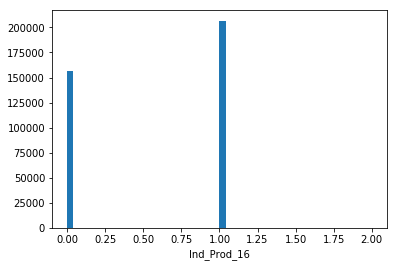

limits (lower,upper) [0.0, 0.0]
Ind_Prod_17 without outliers
Numero de valores anomalos 0


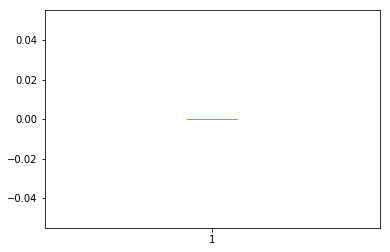

Histograma:


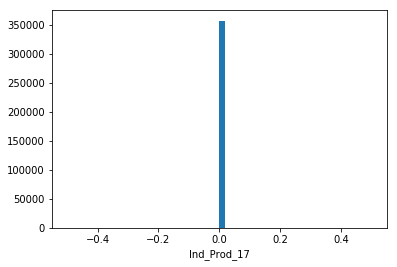

limits (lower,upper) [1.0, 1.0]
Ind_Prod_18 without outliers
Numero de valores anomalos 0


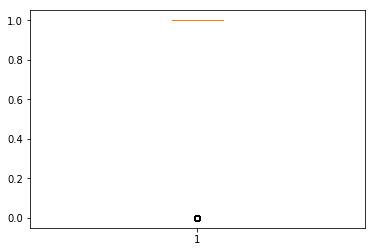

Histograma:


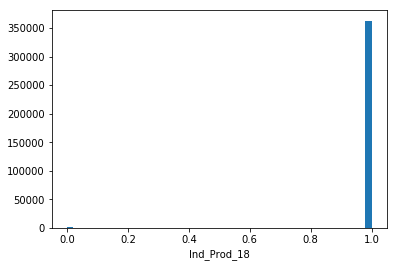

limits (lower,upper) [0.0, 0.0]
Ind_Prod_19 without outliers
Numero de valores anomalos 0


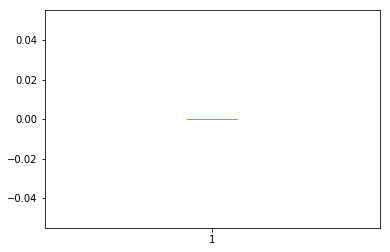

Histograma:


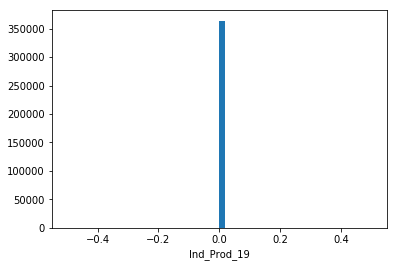

limits (lower,upper) [0.0, 0.0]
Ind_Prod_20 without outliers
Numero de valores anomalos 0


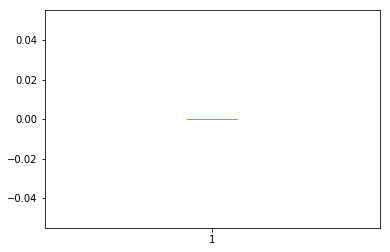

Histograma:


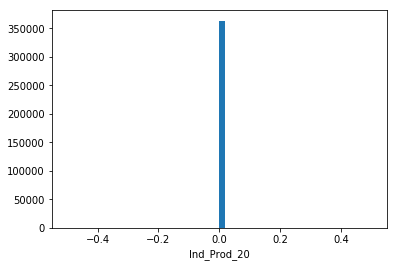

limits (lower,upper) [0.0, 0.0]
Ind_Prod_21 without outliers
Numero de valores anomalos 0


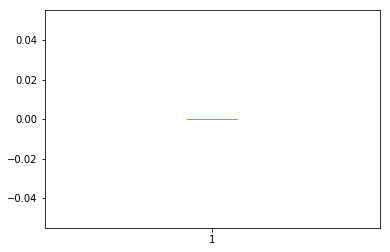

Histograma:


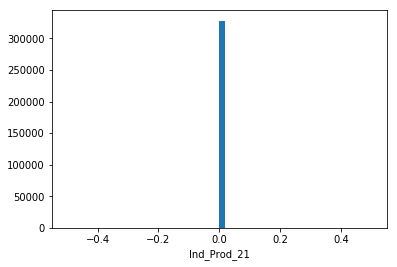

limits (lower,upper) [0.0, 0.0]
Ind_Prod_22 without outliers
Numero de valores anomalos 0


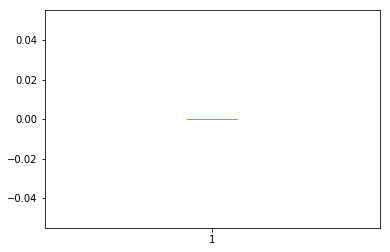

Histograma:


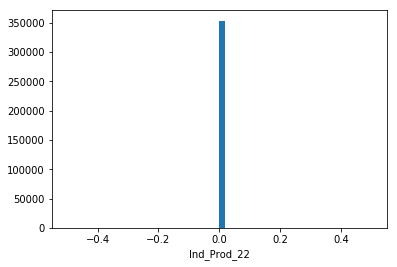

limits (lower,upper) [0.0, 0.0]
Ind_Prod_23 without outliers
Numero de valores anomalos 0


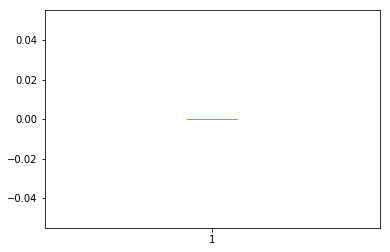

Histograma:


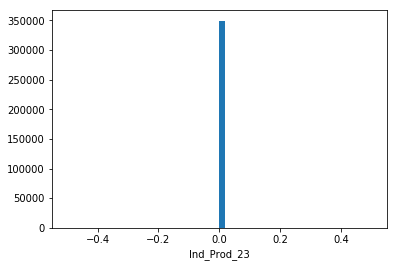

limits (lower,upper) [-0.5, 3.5]
Ind_Prod_24 without outliers
Numero de valores anomalos 0


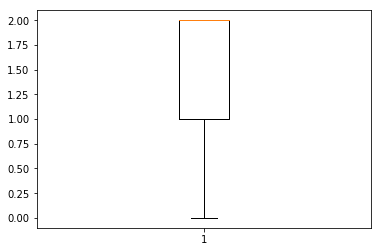

Histograma:


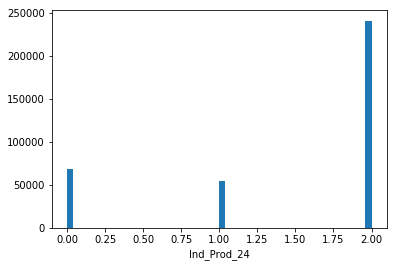

limits (lower,upper) [0.0, 0.0]
Num_Oper_01 without outliers
Numero de valores anomalos 0


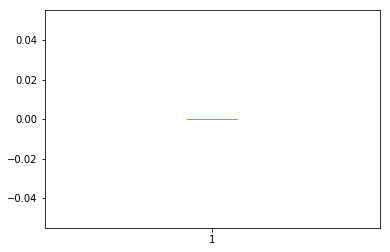

Histograma:


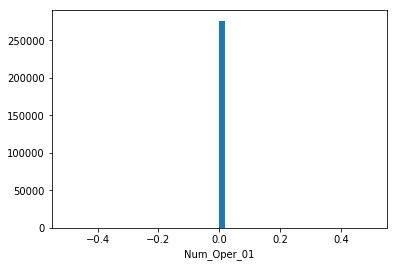

limits (lower,upper) [0.0, 0.0]
Num_Oper_02 without outliers
Numero de valores anomalos 0


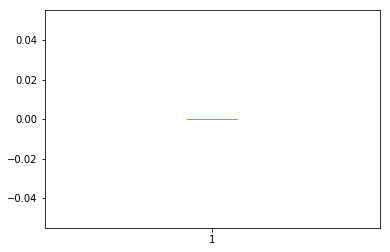

Histograma:


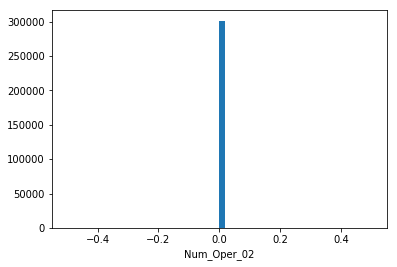

limits (lower,upper) [-12.0, 20.0]
Num_Oper_03 without outliers
Numero de valores anomalos 0


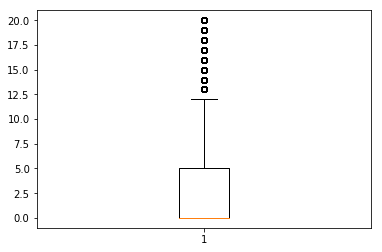

Histograma:


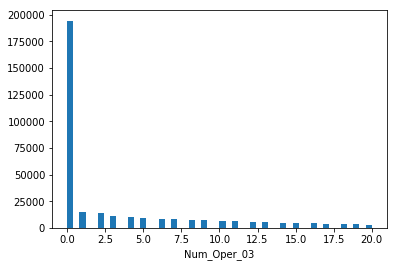

limits (lower,upper) [0.0, 0.0]
Num_Oper_04 without outliers
Numero de valores anomalos 0


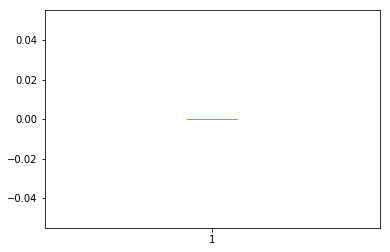

Histograma:


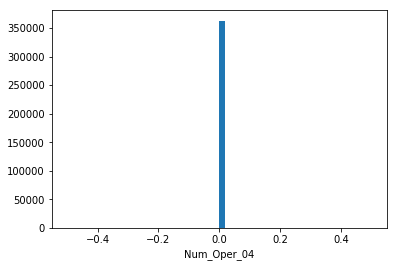

limits (lower,upper) [-19.0, 45.0]
Num_Oper_05 without outliers
Numero de valores anomalos 0


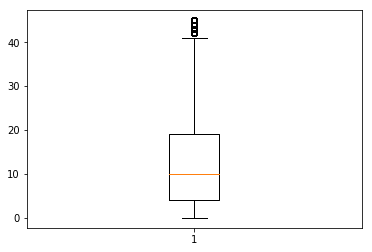

Histograma:


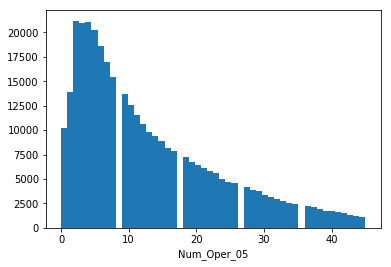

limits (lower,upper) [-2.0, 6.0]
Num_Oper_06 without outliers
Numero de valores anomalos 0


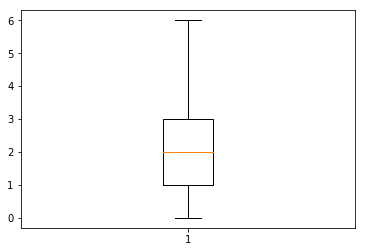

Histograma:


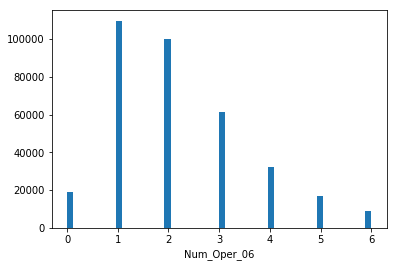

limits (lower,upper) [0.0, 0.0]
Num_Oper_07 without outliers
Numero de valores anomalos 0


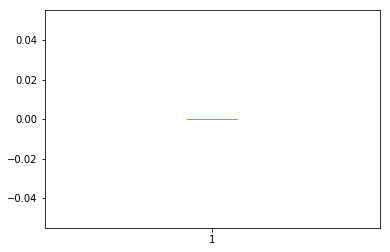

Histograma:


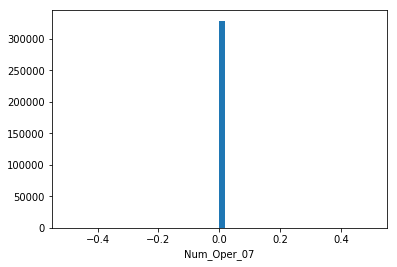

limits (lower,upper) [0.0, 0.0]
Num_Oper_08 without outliers
Numero de valores anomalos 0


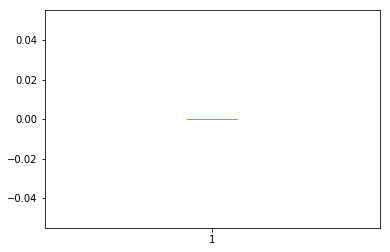

Histograma:


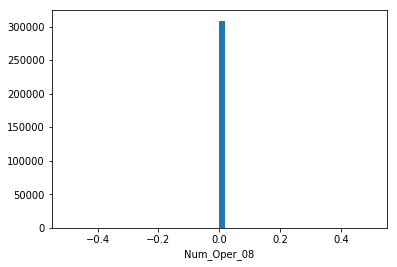

limits (lower,upper) [-4.5, 7.5]
Num_Oper_09 without outliers
Numero de valores anomalos 0


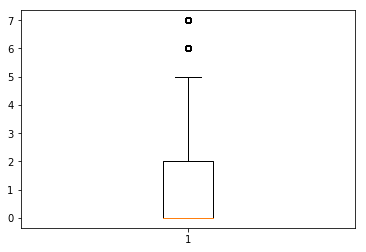

Histograma:


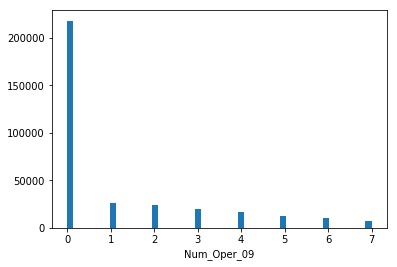

limits (lower,upper) [-7.5, 12.5]
Num_Oper_10 without outliers
Numero de valores anomalos 0


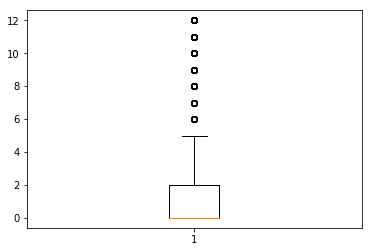

Histograma:


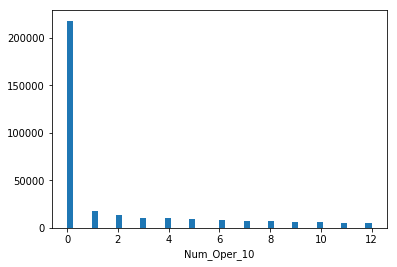

limits (lower,upper) [0.0, 0.0]
Num_Oper_11 without outliers
Numero de valores anomalos 0


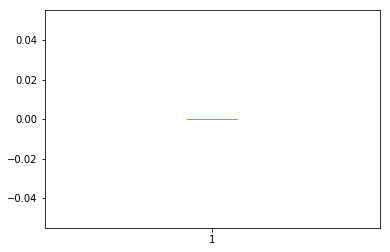

Histograma:


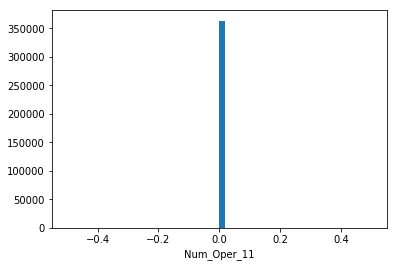

limits (lower,upper) [0.0, 0.0]
Num_Oper_12 without outliers
Numero de valores anomalos 0


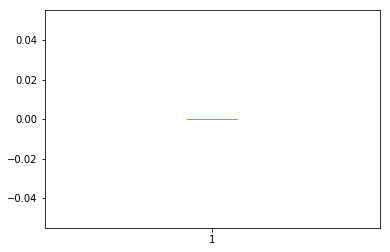

Histograma:


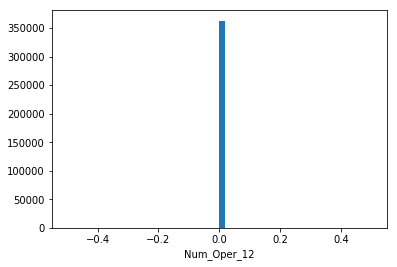

limits (lower,upper) [0.0, 0.0]
Num_Oper_13 without outliers
Numero de valores anomalos 0


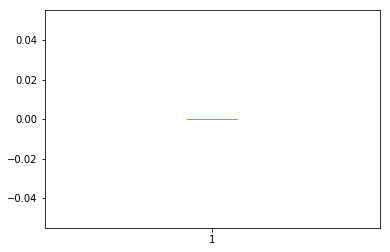

Histograma:


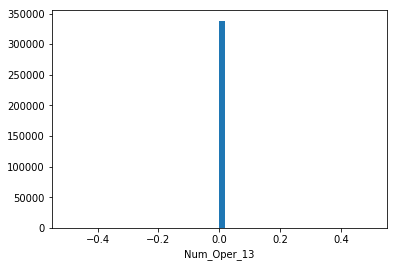

limits (lower,upper) [0.0, 0.0]
Num_Oper_14 without outliers
Numero de valores anomalos 0


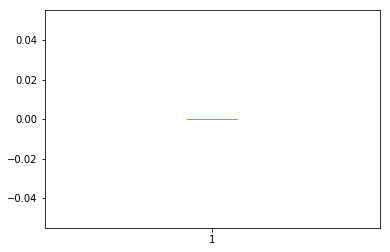

Histograma:


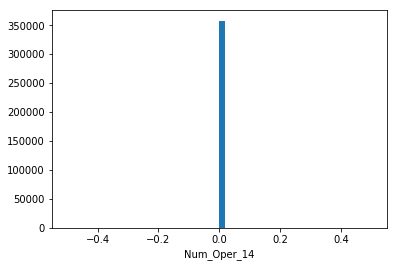

limits (lower,upper) [0.0, 0.0]
Num_Oper_15 without outliers
Numero de valores anomalos 0


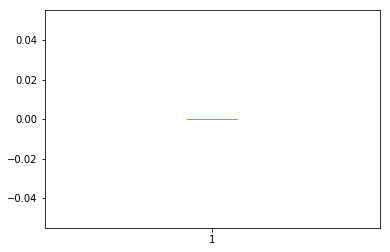

Histograma:


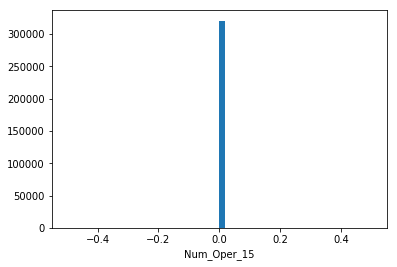

limits (lower,upper) [0.0, 0.0]
Num_Oper_16 without outliers
Numero de valores anomalos 0


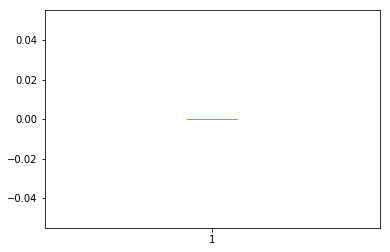

Histograma:


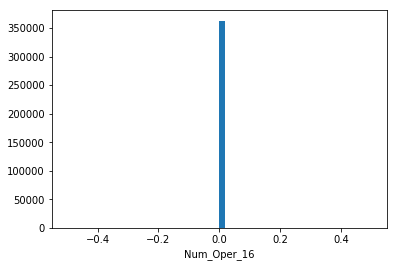

limits (lower,upper) [-5.0, 11.0]
Num_Oper_17 without outliers
Numero de valores anomalos 0


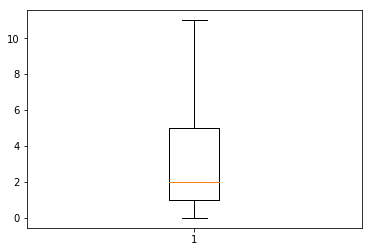

Histograma:


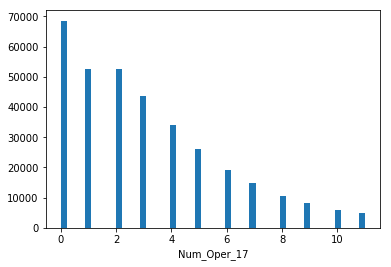

limits (lower,upper) [0.0, 0.0]
Num_Oper_18 without outliers
Numero de valores anomalos 0


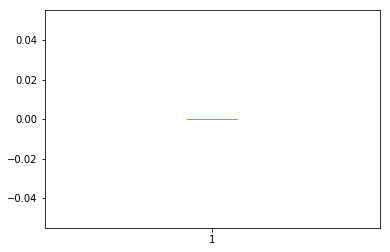

Histograma:


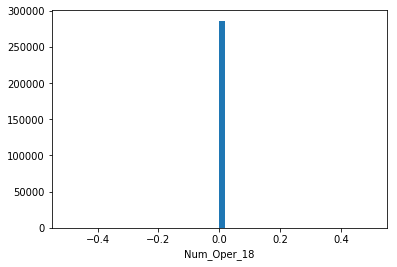

limits (lower,upper) [-1.5, 2.5]
Num_Oper_19 without outliers
Numero de valores anomalos 0


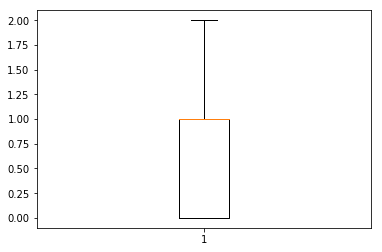

Histograma:


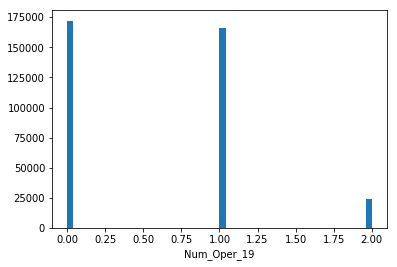

limits (lower,upper) [0.0, 0.0]
Num_Oper_20 without outliers
Numero de valores anomalos 0


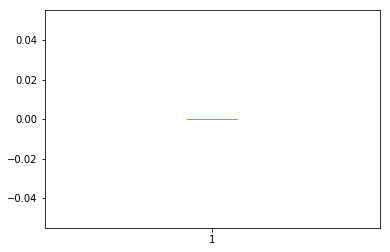

Histograma:


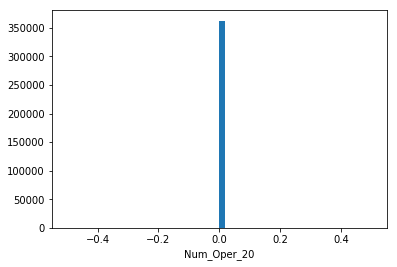

limits (lower,upper) [-0.5, 3.5]
Socio_Demo_02 without outliers
Numero de valores anomalos 0


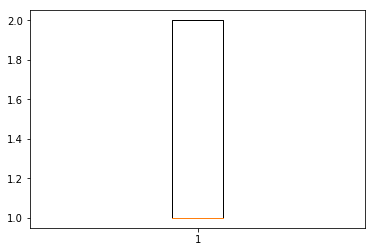

Histograma:


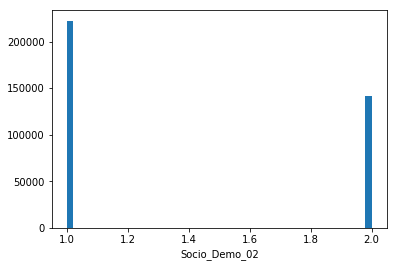

limits (lower,upper) [-8.7599999999999838, 116.83999999999997]
Socio_Demo_03 without outliers
Numero de valores anomalos 0


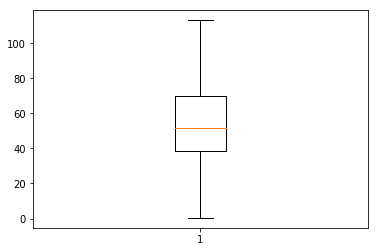

Histograma:


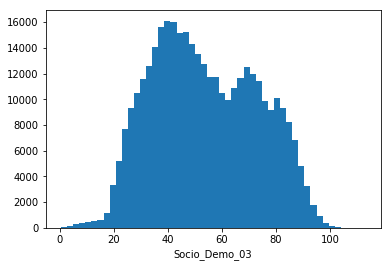

limits (lower,upper) [-2.0, 6.0]
Socio_Demo_04 without outliers
Numero de valores anomalos 0


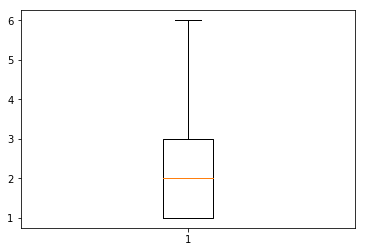

Histograma:


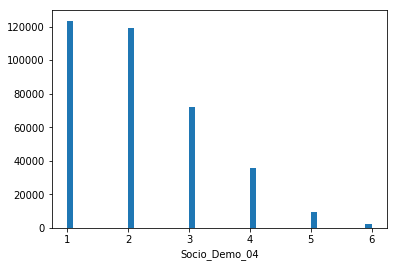

limits (lower,upper) [-12.5, 47.5]
Socio_Demo_05 without outliers
Numero de valores anomalos 0


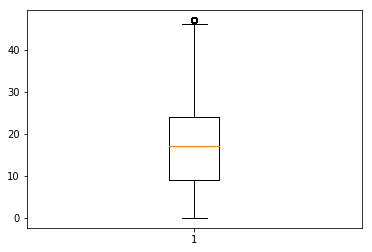

Histograma:


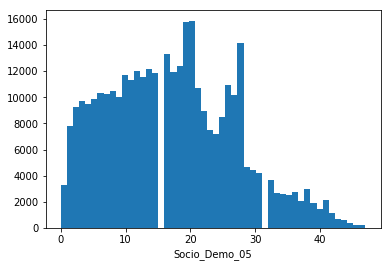

In [16]:
description=traindata['Poder_Adquisitivo'].describe()
print(description)
iqr=description['75%']-description['25%']
limits=[description['25%']-1.5*iqr,description['75%']+1.5*iqr]
#limits=[description['25%']-3*iqr,description['75%']+3*iqr]
print('limits (lower,upper)',limits)
#NO HAY NADIE POR DEBAJO DEL LIMITE INFERIOR
print('Valores anomalos',traindata[traindata['Poder_Adquisitivo']>limits[1]].shape[0])


#COMPROBAMOS EL HISTOGRAMA EXCLUYENDO VALORES ATIPICOS
traindata_no_outliers=traindata[traindata['Poder_Adquisitivo']<=limits[1]]

#SON DEMASIADOS. VOY A QUITAR SOLO A LOS MUY RICOS QUE SOLO SON 33 
traindata=traindata[traindata['Poder_Adquisitivo']<=10000000]

plt.boxplot(traindata_no_outliers['Poder_Adquisitivo'])

#HISTOGRAMA DEL PODER ADQUISITIVO ELIMINANDO OUTLIERS
#Se trata de una distribución asimétrica por la derecha
fig2, ax2 = plt.subplots()
ax2.hist(traindata_no_outliers['Poder_Adquisitivo'],50)
ax2.set_xlabel('Poder_Adquisitivo')
plt.show()


#GENERAMOS DIAGRAMAS DE CAJAS
for col in numeric_cols:
    if(col != 'Poder_Adquisitivo'):
        print(col)
        plt.boxplot(traindata[col])
        plt.show()
        
#GENERAMOS DIAGRAMAS DE CAJAS EXCLUYENDO VALORES ATIPICOS
for col in numeric_cols:
    if(col != 'Poder_Adquisitivo'):
        description_col=traindata[col].describe()
        iqr_col=description_col['75%']-description_col['25%']
        limits_col=[description_col['25%'] - 1.5*iqr_col,description_col['75%'] + 1.5*iqr_col]
        print('limits (lower,upper)',limits_col)
        
        #Excluimos valores atipicos
        traindata_col_no_outliers=traindata[traindata[col]>=limits_col[0]]
        traindata_col_no_outliers=traindata[traindata[col]<=limits_col[1]]
        print(col, 'without outliers')
        lower_outliers = traindata_col_no_outliers[traindata_col_no_outliers[col]<limits[0]].shape[0]
        upper_outliers = traindata_col_no_outliers[traindata_col_no_outliers[col]>limits[1]].shape[0]
        outliers = lower_outliers + upper_outliers
        print('Numero de valores anomalos', outliers)
        plt.boxplot(traindata_col_no_outliers[col])
        plt.show()
        
        #GENERAMOS HISTOGRAMA
        print('Histograma:')
        figcol, axcol = plt.subplots()
        axcol.hist(traindata_col_no_outliers[col],50)
        axcol.set_xlabel(col)
        plt.show()




In [10]:
#VALORES NUMERICOS FALTANTES

missing_values=data.isnull().sum() #obtain the number of missing values by column
numeric_missing=missing_values[numeric_cols] #separate the numeric variables
numeric_missing['Poder_Adquisitivo']=0 #We don't want to detect SalePrice's NAs because they are not real, they just belong to test set
numeric_missing[numeric_missing>0]

#NO FALTAN VALORES NUMERICOS

Series([], dtype: int64)

In [11]:
#VALORES NOMINALES FALTANTES

nominal_missing=missing_values[nominal_cols] 
nominal_missing=nominal_missing[nominal_missing>0]
nominal_missing_df= pd.DataFrame()
nominal_missing_df[['absolute','relative']]= pd.concat([nominal_missing,nominal_missing/data.shape[0]],axis=1)
nominal_missing_df

#HABRA QUE ESTUDIAR BIEN LA COLUMNA Socio_Demo_01, DE MOMENTO ME LA CARGO PARA QUE ESTO FUNCIONE

data=data.drop(['Socio_Demo_01'],axis=1) #remove columns
nominal_cols=nominal_cols[nominal_cols!='Socio_Demo_01']


In [12]:
stdSc = StandardScaler()

numeric_cols=numeric_cols[numeric_cols!='Poder_Adquisitivo'] #We don't want to scale SalePrice

data.loc[:, numeric_cols] = stdSc.fit_transform(data.loc[:, numeric_cols])

In [13]:
#SEPARAMOS DE NUEVO LOS CONJUNTOS

traindata=data.iloc[:traindata.shape[0],:] 
testdata=data.iloc[traindata.shape[0]:,:]
testdata=testdata.drop('Poder_Adquisitivo',axis=1) #We drop the unknown variable in the test. It was just filled with NAs

X_traindata=traindata.drop('Poder_Adquisitivo',axis=1)
y_traindata=traindata['Poder_Adquisitivo']


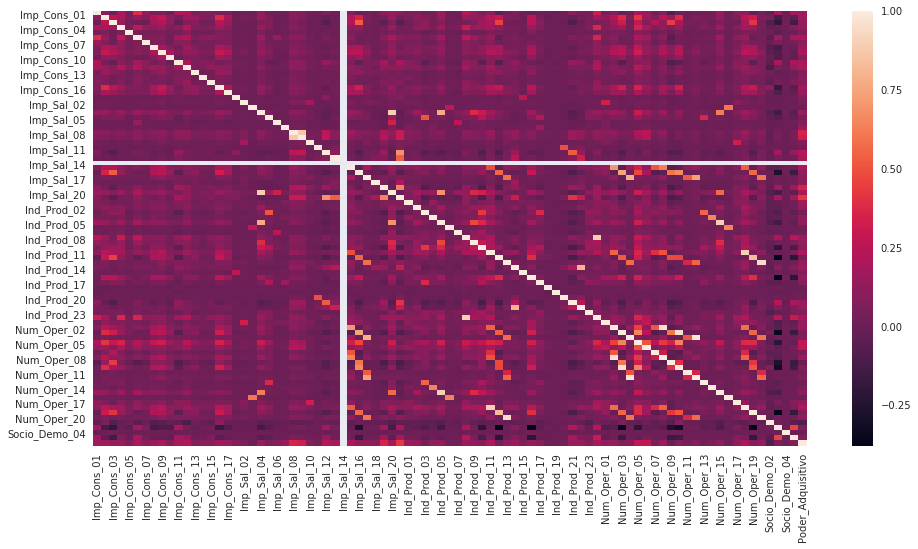

In [14]:
numeric_cols=np.hstack([numeric_cols,'Poder_Adquisitivo'])

#MATRIZ DE CORRELACIONES CON TODAS LAS VARIABLES
correlation=traindata[numeric_cols].corr() #obtain the correlation matrix
sns.set()
fig, ax = plt.subplots(figsize=(16,8))
sns.heatmap(correlation,ax=ax)
plt.show() #draw the correlation matrix

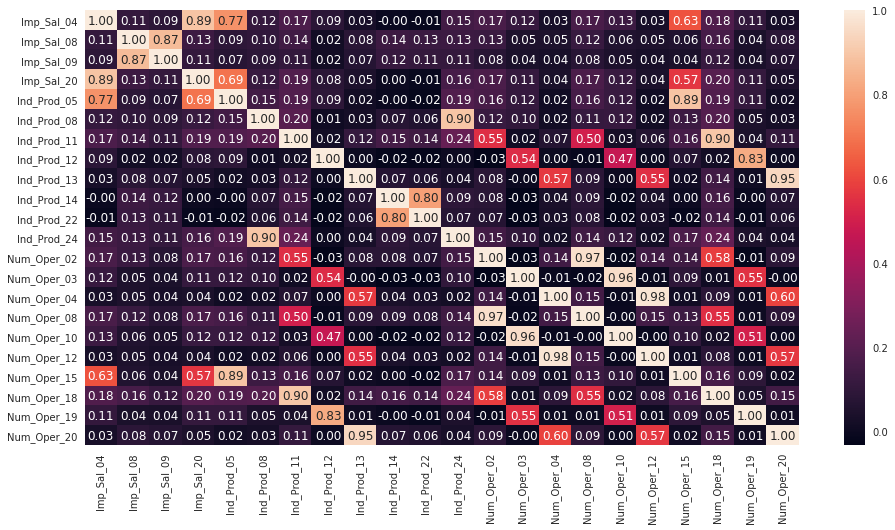

In [15]:
#ESTO ES PARA ENCONTRAR VARIABLES REPETIDAS, LAS QUE TIENEN UNA FUERTE CORRELACION ENTRE ELLAS
#MOSTRAMOS SOLO LAS VARIABLES QUE TIENEN UNA FUERTE CORRELACION CON ALGUNA OTRA
aux=(abs(correlation)-np.identity(correlation.shape[0])).max() #maximum correlation of each variable
selected_feats=aux[aux>0.8].index#take only variables whose maximum correlation is strong.
sns.set()
fig, ax = plt.subplots(figsize=(16,8))
sns.heatmap(correlation.loc[selected_feats,selected_feats], annot=True,fmt='.2f',ax=ax)
plt.show()

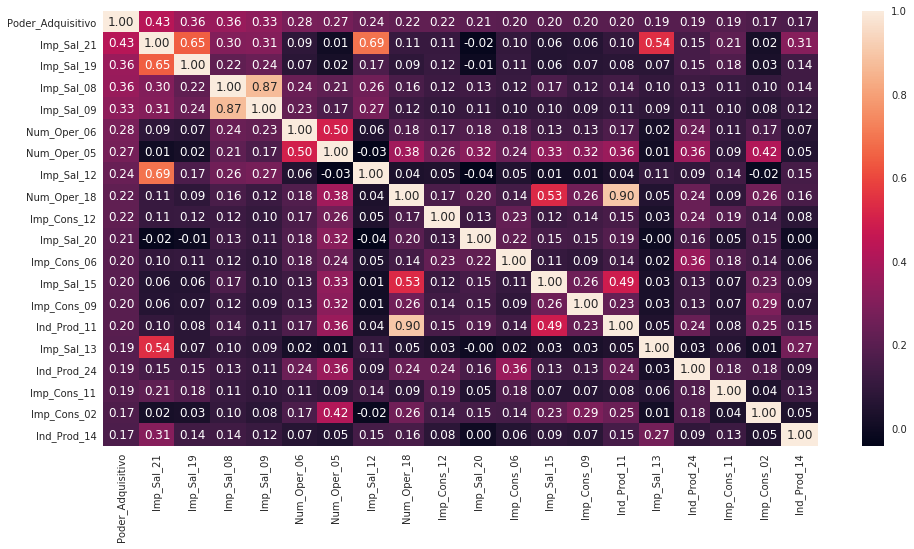

In [18]:
#VAMOS A MOSTRAR LAS SOLO 20 MEJORES VARIABLES
aux=abs(correlation['Poder_Adquisitivo']).sort_values(ascending=False) #sort variables by their correlation with SalePrice
selected_feats=aux[0:20].index
sns.set()
fig, ax = plt.subplots(figsize=(16,8))
sns.heatmap(correlation.loc[selected_feats,selected_feats], annot=True,fmt='.2f',ax=ax)
plt.show()

In [19]:
#MOSTRAR SCATTER MATRIX DE LAS 10 MEJORES VARIABLES SIN CONTAR LA OBJETIVO
selected_feats=aux[1:11].index
sns.set(style="ticks")
sns.pairplot(traindata[selected_feats])
plt.show()

KeyboardInterrupt: 

In [ ]:
#SCATTERS DE LAS VARIABLES MAS IMPORTANTES CON LA OBJETIVO

selected_feats=aux[1:21].index

fig, axes = plt.subplots(nrows=5,ncols=4,figsize=(16,32),sharey=True)
axes=axes.flatten()
for i in range(len(axes)):
    axes[i].scatter(traindata[selected_feats[i]],traindata['Poder_Adquisitivo'])
    axes[i].set_xlabel(selected_feats[i])
    axes[i].set_ylabel('Poder_Adquisitivo')
plt.show()

In [30]:
#ESTIMAMOS LOS PARAMETROS DE RIDGE
ridgealpha=RidgeCV([0.05,0.1,0.3,0.6,1,1.5,3,5,10,15,30,50,80],n_jobs=-1).fit(X_traindata,y_traindata).alpha_
ridgealpha

TypeError: __init__() got an unexpected keyword argument 'n_jobs'

In [ ]:
#ESTIMAMOS LOS PARAMETROS DE LASSO

lassoalpha =LassoCV(alphas=[0.0001, 0.0003, 0.0006, 0.001, 0.003, 0.006, 0.01, 0.03, 0.06, 0.1, 
                          0.3, 0.6, 1.0],n_jobs=-1).fit(X_traindata,y_traindata).alpha_
lassoalpha

In [ ]:
#ESTIMAMOS LOS PARAMETROS DE ELASTICNET

elasticNet = ElasticNetCV(l1_ratio = [0.1, 0.3, 0.5, 0.6, 0.7, 0.8, 0.85, 0.9, 0.95, 1],
                          alphas = [0.0001, 0.0003, 0.0006, 0.001, 0.003, 0.006, 
                                    0.01, 0.03, 0.06, 0.1, 0.3, 0.6, 1, 3, 6],n_jobs=-1).fit(X_traindata,y_traindata)
elasticalpha=elasticNet.alpha_
elasticl1=elasticNet.l1_ratio_


In [ ]:
#ESTA FUNCIÓN CALCULA EL ERROR ABSOLUTO MEDIO CON CROSS VALIDATION
def rmse_cv(model,X, y):
    return -cross_val_score(model, X, y, scoring = scorer, cv = 10)
#mean_absolute_error
scorer = make_scorer(mean_absolute_error, greater_is_better = False)

#AHI ESTA LA LISTA DE REGRESORES QUE VA A PROBAR. 
#ESTAN PUESTOS UNO EN CADA LINEA PARA QUE SEA SENCILLO COMENTAR UNO SIN TOCAR LOS OTROS
#YA QUE TIENES MAS POTENCIA DE COMPUTO, TE INSTO A QUE JUEGUES CON LOS PARAMETROS DE KERNELRIDGE, DE HUBREGRESSOR Y DE RANDOMFOREST
regressors=[Ridge(ridgealpha), #RAPIDO Y BIEN
            Lasso(lassoalpha), #TARDABA MUCHO Y LO HE PARADO
            ElasticNet(l1_ratio=elasticl1,alpha=elasticalpha), #AUN NO LA HE PROBADO
            KNeighborsRegressor(n_jobs=-1), #TARDABA MUCHO Y LO HE PARADO
            KernelRidge(kernel='poly'), # POR DEFECTO ES GRADO 3. AUN NO LA HE PROBADO
            KernelRidge(kernel='poly', degree=2), #AUN NO LA HE PROBADO
            KernelRidge(kernel='rbf'), #AUN NO LA HE PROBADO
            HuberRegressor(), #ESTE NO ME SUENA DE NADA, PERO PONIA QUE ERA ROBUSTO A OUTLIERS. #AUN NO LA HE PROBADO
            RandomForestRegressor(100, max_features='sqrt',max_depth=10, n_jobs=-1)] #TARDA UNOS MINUTOS, BUEN RESULTADO

results={'Regressor':[],'error':[]}

for regressor in regressors:
    print('INICIO', regressor)
    results['Regressor'].append(str(regressor.__class__).split('.')[-1].split("'")[0])
    res=rmse_cv(regressor,X_traindata,y_traindata).mean()
    results['error'].append(res)
        print(res) #show the estimate of the test error

#GUARDAMOS LOS RESULTADOS
results=pd.DataFrame(results['error'], index=results['Regressor'], columns=['Mean absolute cross validation error'])
results.to_csv('results.csv',sep=',')
